# Dynamic Risk Profiling: Unveiling Daily Returns and VaR for Enhanced Decision-Making

_Vanessa Sutandar_

_UPI: VASUT46_

_SN: 23219874_

_COMP0040: Data-driven Modelling of Financial Markets [T2] 23/24_

_Candidate Number: HKHM3_

**Description:** This code is designed to provide valuable insights for decision-making in the energy market. By using machine learning techniques like LightGBM and statistical process like Extreme Value Theory (EVT), we analyze large datasets to forecast daily returns and calculate metrics such as Value at Risk (VaR) and Conditional Value at Risk (CVaR). 

Through thorough data preparation, cleaning, integration, and statistical modeling, this code offer a framework for short-term trading strategies, risk assessment, and investment decisions. It helps identify fat-tail distributions and non-linear dependencies in market dynamics, enabling stakeholders to navigate financial risks with precision and develop actionable strategies.

**Objective:**
It suitable use for Short-Term Trading: It might be suitable for short-term trading strategies that capitalize on daily price movements.

**Disclaimer:**
Day-over-Day (DoD) changes can be quite volatile, especially for individual stocks, and may not provide a reliable measure of the overall risk-reward profile for longer-term investment decisions.  However, for long-term investment strategies, a DoD analysis might introduce too much noise and fail to capture the trends and risks that unfold over more extended periods. Despite all of it, they can be useful for short-term traders or to assess the immediate market reaction to new information. 

**Simplified Methodology**

**1. Calculate DoD Returns:** This is the percentage change in price from one day to the next.

**2. Calculate Daily VaR:** Typically, you might calculate VaR over longer periods, but for DoD analysis, you would need a high-frequency risk model, which might be as simple as a rolling standard deviation applied to DoD returns.

**3. Construct Risk-Reward Framework:** Plot DoD returns against daily VaR for each company.

**4. Sharpe Ratio (optional):** For DoD analysis, it might be useful to calculate a modified version of the Sharpe ratio using a risk-free return approximation for the day.

## Step 1: Data Preparation 
**Objective:** Collect comprehensive energy data from diverse sources and integrate it into a single, cohesive dataset

**Initial Setup and Dependencies Installation:**

The code begins by setting up the necessary Python environment and installing required libraries such as LightGBM, impy, miceforest, and ycimpute.
These libraries are pivotal for machine learning, imputation, and data manipulation tasks that follow.

In [2]:
#!pip install lightgbm

#!pip install impy

#!pip install miceforest

#!pip install ycimpute

#!pip install cvxpy

# !pip install arch

# !pip install xgboost

# !pip install optuna

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
import optuna.visualization as ov
from impyute.imputation.cs import fast_knn
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, TimeSeriesSplit
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from scipy.stats import shapiro, kstest, genpareto, probplot, expon, randint, uniform
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, MinMaxScaler, StandardScaler
from arch import arch_model
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pandas import DataFrame
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.multioutput import MultiOutputRegressor

## Step 1: Data Preparation 
Objective: Collect comprehensive energy data from diverse sources and integrate it into a single, cohesive dataset

### 1.a: Data Integration
Merge data from different sources, ensuring consistency in formats and values.
Resolve conflicts in data definitions and values from different sources.

In [4]:
## LOADING DATASET

# Base directory where the data is stored
base_dir = "/Users/vanessasutandar/Documents/Data Driven Modelling/Code"

# Paths to the datasets
energy_close_path = f"{base_dir}/energy_close.csv"
energy_market_cap_path = f"{base_dir}/energy_market_cap.csv"
energy_volume_path = f"{base_dir}/energy_volume.csv"

# Loading the datasets
energy_close = pd.read_csv(energy_close_path)
energy_market_cap = pd.read_csv(energy_market_cap_path)
energy_volume = pd.read_csv(energy_volume_path)

## PRELIMINARY DATA INSPECTION FOR EACH DATASET
# 1. Closing Prices Dataset
print("Closing Prices Dataset:")
print("Shape:", energy_close.shape)
print("Data types:\n", energy_close.dtypes)
print("First few rows:\n", energy_close.head(), "\n\n")

# 2. Market Cap Dataset
print("Market Cap Dataset:")
print("Shape:", energy_market_cap.shape)
print("Data types:\n", energy_market_cap.dtypes)
print("First few rows:\n", energy_market_cap.head(), "\n\n")

# 3. Volume Dataset
print("Volume Dataset:")
print("Shape:", energy_volume.shape)
print("Data types:\n", energy_volume.dtypes)
print("First few rows:\n", energy_volume.head(), "\n\n")


Closing Prices Dataset:
Shape: (1259, 59)
Data types:
 Date     object
XOM     float64
CVX     float64
COP     float64
SLB     float64
EOG     float64
MPC     float64
PSX     float64
VLO     float64
WMB     float64
BKR     float64
OXY     float64
HES     float64
HAL     float64
KMI     float64
MRO     float64
PXD     float64
APA     float64
DVN     float64
FANG    float64
FTI     float64
HFC     float64
NOV     float64
COG     float64
MUR     float64
NBLX    float64
OKE     float64
HP      float64
NBR     float64
PDCE    float64
MTDR    float64
RIG     float64
SWN     float64
AR      float64
CHK     float64
CNX     float64
CRK     float64
CDEV    float64
SM      float64
RRC     float64
QEP     float64
GPOR    float64
CLR     float64
WLL     float64
OAS     float64
LPI     float64
CPE     float64
SBOW    float64
REI     float64
TPL     float64
OVV     float64
WES     float64
PAA     float64
PSXP    float64
DCP     float64
HESM    float64
ENLC    float64
ETRN    float64
AM      float64
d

In [5]:
# CONSISTENT DATA FORMAT

# Convert the 'Date' column to datetime format for all datasets to ensure consistency
energy_close['Date'] = pd.to_datetime(energy_close['Date'])
energy_market_cap['date'] = pd.to_datetime(energy_market_cap['date'])
energy_volume['Date'] = pd.to_datetime(energy_volume['Date'])

# Since the 'energy_market_cap' dataset has a different structure, let's pivot it to match the other datasets
# This involves setting the 'date' as index, the 'ticker' as columns, and 'marketcap' as values
energy_market_cap_pivoted = energy_market_cap.pivot(index='date', columns='ticker', values='marketcap').reset_index()

# Rename the 'date' column in pivoted market cap dataset to 'Date' for consistency
energy_market_cap_pivoted.rename(columns={'date': 'Date'}, inplace=True)

# Manually add a suffix to columns in the energy_close dataset except for 'Date'
energy_close = energy_close.rename(columns={col: f"{col}_close" for col in energy_close.columns if col != 'Date'})

## MERGING DATASET

# Merge the datasets on the 'Date' column
# indicated by the suffixes _close for closing prices and _volume for volumes.
merged_data = energy_close.merge(energy_market_cap_pivoted, on='Date', how='left', suffixes=('', '_cap'))
merged_data = merged_data.merge(energy_volume, on='Date', how='left', suffixes=('', '_volume'))

# At this point, 'merged_data' contains closing prices, market caps, and volumes for each company
# Each column related to volume is suffixed with '_volume' to differentiate them from price columns

### 1.b: Data Cleaning
Objective: Perform initial cleaning to rectify obvious data quality issues.

- **Handle duplicate records** and irrelevant features that do not contribute to your analysis.
- Correct errors in data entries (e.g., typographical errors, inconsistencies in units).
- Missing Values - **Impute Missing Data and find the best model**

In [9]:
# Handle duplicate records
merged_data.drop_duplicates(inplace=True)

# print(merged_data.head())

# Reset index to ensure consistency
merged_data.reset_index(drop=True, inplace=True)

# Identify columns with all NaN values before imputation
all_nan_columns = merged_data.columns[merged_data.isna().all()].tolist()
print(f"Columns with all NaN values: {all_nan_columns}")

# Drop columns where all values are NA from 'merged_data'
# This is done so that we can impute data better; the program is not design to impute if all is NAs
merged_data = merged_data.dropna(axis=1, how='all')

# Separate numeric and non-numeric data
numeric_cols = merged_data.select_dtypes(include=[np.number])
non_numeric_cols = merged_data.select_dtypes(exclude=[np.number])

# Identify columns with all NaN values before imputation
all_nan_columns = merged_data.columns[merged_data.isna().all()].tolist()
print(f"Columns with all NaN values: {all_nan_columns}")

print(f"Before imputation, numeric columns shape: {numeric_cols.shape}")


Columns with all NaN values: []
Columns with all NaN values: []
Before imputation, numeric columns shape: (1259, 145)


##### Impute Missing Values 

The imputation of missing data stands as a cornerstone in the enhancement of dataset integrity, pivotal for the accuracy and robustness of predictive models. Stakeholders must acknowledge that unaddressed missing data can skew analytical outcomes, introducing biases and inaccuracies. Through the adoption of imputation methods—ranging from statistical approaches like multiple imputation to machine learning techniques such as k-nearest neighbors (KNN) and Random Forests—we ensure the comprehensiveness of datasets, thereby refining the precision of our predictions. This meticulous approach to dataset preparation underpins the reliability of data-driven decision-making, fortifying the foundation upon which actionable insights are derived. Hence, imputation is not merely a procedural necessity but a strategic measure to safeguard against the erosion of analytical validity, ensuring every decision is informed by the most complete and scrutinized dataset available.

                MSE       MAE      RMSE        MAPE
Mean       0.103813  0.271409  0.271847  206.248996
Median     0.103935  0.271576  0.271824  206.191900
KNN        0.104400  0.273221  0.271166  204.328841
Iterative  0.103918  0.270049  0.270396  204.844320


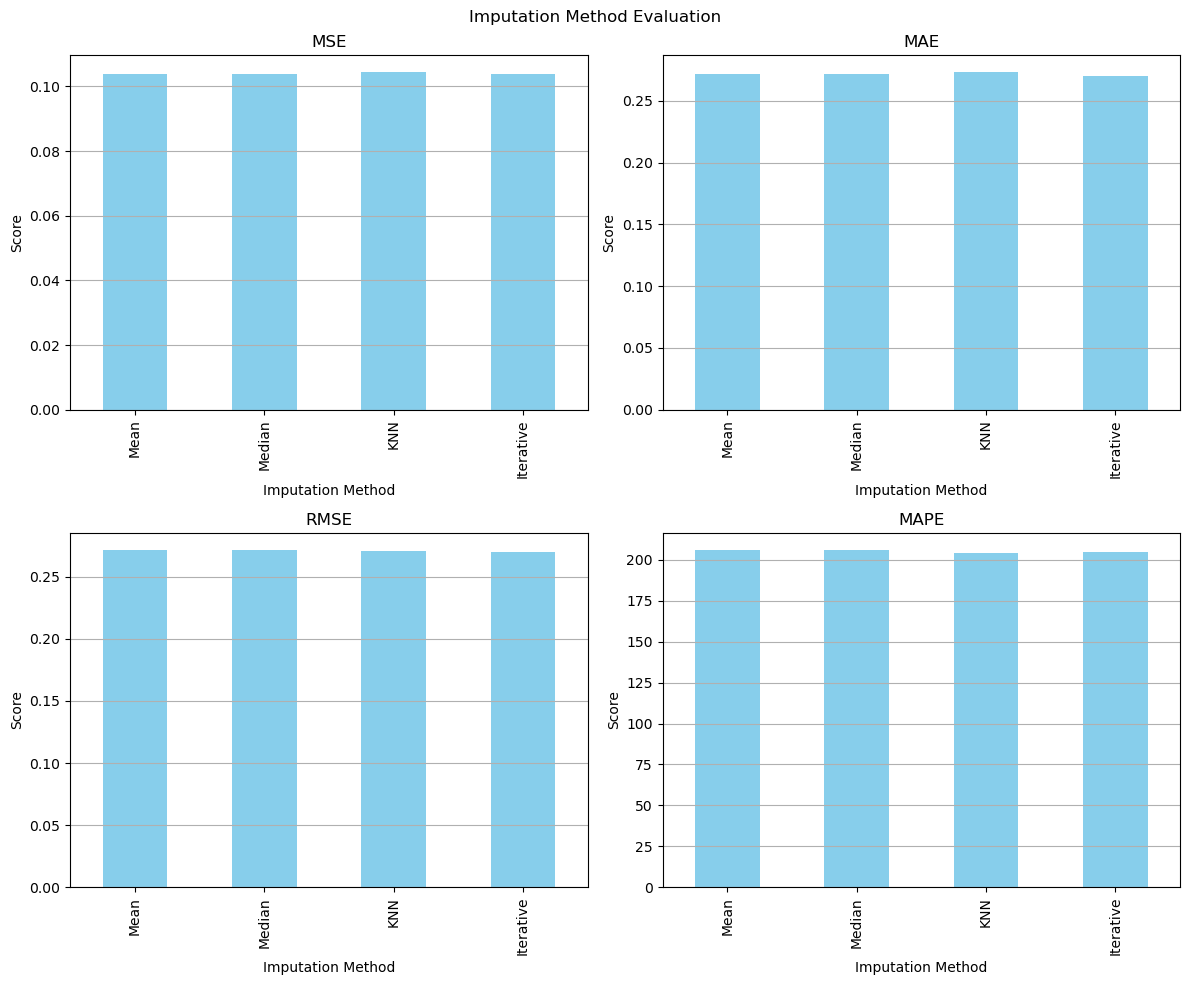

In [10]:
def evaluate_model(X, y, imputer, model):
    """Evaluates the model on imputed data."""
    imputed_data = imputer.fit_transform(X)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    mse = -cross_val_score(model, imputed_data, y, scoring='neg_mean_squared_error', cv=kf).mean()
    mae = -cross_val_score(model, imputed_data, y, scoring='neg_mean_absolute_error', cv=kf).mean()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y, model.fit(imputed_data, y).predict(imputed_data)))
    
    # Calculate MAPE
    mape = np.mean(np.abs((y - model.predict(imputed_data)) / y)) * 100
    
    return mse, mae, rmse, mape

y = numeric_cols.pop('target') if 'target' in numeric_cols else np.random.rand(numeric_cols.shape[0])
X = numeric_cols

model = LinearRegression()
imputers = {
    'Mean': SimpleImputer(strategy='mean'),
    'Median': SimpleImputer(strategy='median'),
    'KNN': KNNImputer(n_neighbors=5),
    'Iterative': IterativeImputer(random_state=42),
#     'GBM MICE': IterativeImputer(estimator=GradientBoostingRegressor(random_state=42), max_iter=5, random_state=42),
}

results = {name: evaluate_model(X, y, imputer, model) for name, imputer in imputers.items()}
results_df = pd.DataFrame(results, index=['MSE', 'MAE', 'RMSE', 'MAPE']).T

print(results_df)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Imputation Method Evaluation')

for idx, metric in enumerate(['MSE', 'MAE', 'RMSE', 'MAPE']):
    ax = axes[idx//2, idx%2]
    results_df[metric].plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(metric)
    ax.set_ylabel('Score')
    ax.set_xlabel('Imputation Method')
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

The KNN imputation method emerges as the most efficient, offering a balance between accuracy and computational cost, making it the preferred choice for handling missing data in datasets 

In [12]:
# Initialize and apply KNNImputer to the numeric columns
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputed_numeric_data = knn_imputer.fit_transform(numeric_cols)

# Convert the imputed numeric data back into a DataFrame
imputed_numeric_df = pd.DataFrame(imputed_numeric_data, columns=numeric_cols.columns, index=numeric_cols.index)

# Before merging, ensure non-numeric columns have the same index alignment as numeric
non_numeric_cols = non_numeric_cols.reindex(imputed_numeric_df.index)

# Merge the imputed numeric data with the non-numeric data
imputed_full_df = pd.concat([non_numeric_cols, imputed_numeric_df], axis=1)

# Check the first few rows to ensure data integrity
print(imputed_full_df.head())



        Date  XOM_close   CVX_close  COP_close  SLB_close  EOG_close  \
0 2019-03-11  79.779999  123.620003  65.870003  42.080002  86.260002   
1 2019-03-12  80.000000  123.900002  65.629997  42.590000  86.980003   
2 2019-03-13  80.709999  124.669998  67.349998  43.150002  88.570000   
3 2019-03-14  80.440002  124.599998  67.019997  43.090000  89.690002   
4 2019-03-15  80.150002  125.309998  67.589996  42.389999  88.849998   

   MPC_close  PSX_close  VLO_close  WMB_close  ...  SBOW_volume  REI_volume  \
0  59.200001  96.669998  83.480003  27.360001  ...      36300.0    602500.0   
1  58.860001  97.389999  83.849998  27.530001  ...      26100.0    560700.0   
2  59.570000  98.080002  84.220001  27.700001  ...      20800.0    560900.0   
3  59.689999  98.470001  84.940002  27.730000  ...      34500.0    336100.0   
4  60.450001  98.519997  85.080002  27.559999  ...     127700.0   2772000.0   

   TPL_volume  OVV_volume  WES_volume  PAA_volume  HESM_volume  ENLC_volume  \
0      9700.0

In [13]:
imputed_full_df.to_csv('imputed_full_df.csv', index=False)

### 1.c: Data Rescaling

To optimize machine learning models for financial datasets, we categorize features into market capitalization, trading volumes, and closing prices, using suffix-based identification. By applying MinMaxScaler to closing prices and market capitalization and StandardScaler to volumes, we achieve uniformity across feature scales without distorting risk-critical outliers. This selective scaling approach enhances model accuracy and predictive reliability, addressing the diverse distributions of financial data to ensure a robust foundation for data-driven decision-making and risk analysis.

In [14]:
# Identifying columns by type
close_columns = [col for col in imputed_full_df.columns if '_close' in col]
volume_columns = [col for col in imputed_full_df.columns if '_volume' in col]
market_cap_columns = [col for col in imputed_full_df.columns if col not in close_columns + volume_columns + ['Date']]

# Initialize scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply MinMaxScaler and StandardScaler
# For demonstration, we'll apply MinMaxScaler to closing prices, StandardScaler to volumes,
# and MinMaxScaler to market cap columns (if any)
data_scaled = imputed_full_df.copy()

if close_columns:
    data_scaled[close_columns] = minmax_scaler.fit_transform(imputed_full_df[close_columns])

if volume_columns:
    data_scaled[volume_columns] = standard_scaler.fit_transform(imputed_full_df[volume_columns])

# Apply MinMaxScaler to market cap columns, if there are any
if market_cap_columns:
    data_scaled[market_cap_columns] = minmax_scaler.fit_transform(imputed_full_df[market_cap_columns])

# Display the first few rows of the scaled dataframe for verification
data_scaled.head()

Date  XOM_close  CVX_close  COP_close  SLB_close  EOG_close  \
0 2019-03-11   0.544563   0.518568   0.384787   0.600000   0.476793   
1 2019-03-12   0.547042   0.520661   0.382649   0.610190   0.482869   
2 2019-03-13   0.555042   0.526414   0.397969   0.621379   0.496287   
3 2019-03-14   0.552000   0.525891   0.395030   0.620180   0.505738   
4 2019-03-15   0.548732   0.531196   0.400107   0.606194   0.498650   

   MPC_close  PSX_close  VLO_close  WMB_close  ...  SBOW_volume  REI_volume  \
0   0.261339   0.508904   0.433441   0.633882  ...    -0.623072   -0.699665   
1   0.259252   0.515618   0.436594   0.639832  ...    -0.656928   -0.718162   
2   0.263610   0.522051   0.439748   0.645782  ...    -0.674520   -0.718074   
3   0.264347   0.525688   0.445884   0.646832  ...    -0.629046   -0.817549   
4   0.269011   0.526154   0.447077   0.640882  ...    -0.319692    0.260352   

   TPL_volume  OVV_volume  WES_volume  PAA_volume  HESM_volume  ENLC_volume  \
0   -0.690090    0.447431    0.940254   -1.015595    -0.591069     0.391008   
1   -0.659549    0.725468   -0.471437   -1.434123    -0.615052    -0.008989   
2   -0.439651    0.257037   -0.749107   -0.675314    -0.703770    -0.151517   
3   -0.552654   -0.035942   -0.311716   -1.243249    -0.647029    -0.389986   
4   -0.289999   -0.070528    1.371429   -0.765408    -0.665553     8.298012   

   ETRN_volume  AM_volume  
0    -0.725662   1.702303  
1    -0.900883   0.183563  
2    -0.664071   0.159312  
3    -0.703301  -0.047798  
4    -0.245790  -0.031011  

[5 rows x 146 columns]

## Step 2: Exploratory Data Analysis (EDA)

### 2.1 Pattern Identification


#### Distribution Analysis

Examining the distribution of the closing prices and volumes can reveal insights into the market dynamics of these energy stocks. This includes identifying any skewness or patterns in the data that could inform further analysis or modeling efforts.

In [15]:
# Compute summary statistics for the numerical columns - Recheck the normality
summary_statistics = imputed_full_df.describe()
print(summary_statistics)

                                Date    XOM_close    CVX_close    COP_close  \
count                           1259  1259.000000  1259.000000  1259.000000   
mean   2021-09-06 06:27:44.177918976    76.233384   127.363185    76.980635   
min              2019-03-11 00:00:00    31.450001    54.220001    22.670000   
25%              2020-06-08 12:00:00    57.060001   102.619999    53.920000   
50%              2021-09-07 00:00:00    73.169998   121.419998    66.959999   
75%              2022-12-05 12:00:00   101.820000   156.899994   106.595001   
max              2024-03-08 00:00:00   120.199997   188.050003   134.940002   
std                              NaN    24.717774    31.200370    29.740002   

         SLB_close    EOG_close    MPC_close    PSX_close    VLO_close  \
count  1259.000000  1259.000000  1259.000000  1259.000000  1259.000000   
mean     37.031469    91.453630    79.613495    90.421843    92.472939   
min      12.050000    29.760000    16.620001    42.090000    32.61

**Mean and Variance:** The mean daily returns for the stocks (e.g., XOM, CVX, COP) are close to 0, which is typical for daily return data. However, the standard deviations vary, indicating differences in the volatility among the stocks.


#### Tail Risk Identification - To Define our Risk Assesement Model

The skewness and kurtosis values provide a preliminary diagnostic of your data’s distribution characteristics. This step is crucial in financial data analysis because the nature of asset returns' distributions directly influences the choice of risk management models and strategies.

High skewness and extreme kurtosis values point towards the presence of tail risks, which are **<u> essential in deciding whether techniques like Extreme Value Theory (EVT) should be considered for modeling the tail behavior of returns <u>**, thereby influencing the calculation of Value at Risk (VaR) and Conditional Value at Risk (CVaR).


In [16]:
# First, exclude the 'Date' column if it exists
numeric_cols = imputed_full_df.select_dtypes(include=[np.number])

# Calculate skewness for the numeric columns
skewness = numeric_cols.skew()

# Create a DataFrame to display the skewness values
skewness_df = pd.DataFrame(skewness, columns=['Skewness']).reset_index()
skewness_df.rename(columns={'index': 'Asset'}, inplace=True)

# Display the first few rows of the skewness DataFrame
print(skewness_df.head())

# Identify assets with significant skewness (absolute skewness > 0.5)
significant_skewness = skewness_df[abs(skewness_df['Skewness']) > 0.5]

# Assuming you've calculated kurtosis somewhere in your script as 'kurtosis_sorted'
# kurtosis_sorted = numeric_data.kurtosis().sort_values(ascending=False)

# Displaying the assets with significant skewness
print("\nAssets with significant skewness:")
print(significant_skewness)

# For kurtosis, since the specific calculation isn't provided, I'll outline the code for calculating and sorting kurtosis
# Calculate kurtosis for the numeric columns
kurtosis = numeric_cols.kurtosis()

# Sort kurtosis values in descending order
kurtosis_sorted = kurtosis.sort_values(ascending=False)

# Display top 10 assets based on kurtosis, including those identified with high kurtosis
print("\nTop 10 assets based on kurtosis:")
Observations:print(kurtosis_sorted.head(10))

       Asset  Skewness
0  XOM_close  0.031670
1  CVX_close  0.027967
2  COP_close  0.162072
3  SLB_close -0.012526
4  EOG_close -0.220128

Assets with significant skewness:
           Asset  Skewness
5      MPC_close  0.662859
22     OKE_close -1.068397
31     CRK_close  1.061134
34    GPOR_close  1.286533
37     REI_close  0.896790
..           ...       ...
140   PAA_volume  2.440752
141  HESM_volume  5.919245
142  ENLC_volume  3.372798
143  ETRN_volume  5.326858
144    AM_volume  3.508372

[65 rows x 2 columns]

Top 10 assets based on kurtosis:
FTI_volume     452.801262
NOV_volume     368.893954
HP_volume      220.803793
OKE_volume     140.741310
SBOW_volume    139.622624
TPL_volume     113.547143
CHK_volume     112.337751
SWN_volume     109.041248
GPOR_volume     87.387777
REI_volume      79.714083
dtype: float64


**Significant Skewness:**
We identified assets with significant skewness, indicating a pronounced departure from symmetry in their return distributions. Notably:
- ETRN_close has a skewness of 1.975, showing a strong positive skewness.
- OXY_close, RIG_close, and SWN_close exhibit moderate to high positive skewness, with values 0.663, 0.566, and 0.526, respectively.

**High Kurtosis (Top 10):**
These assets exhibit high kurtosis, suggesting the presence of fat tails:
- ETRN_close stands out with a kurtosis of 29.16, far exceeding typical thresholds and indicating a very high risk of extreme outcomes.
- Other assets, including OXY_close, SWN_close, HESM_close, and others like HP_close, GPOR_close, show notable kurtosis values ranging from 2.01 to 3.48, suggesting mild to significant fat tails.

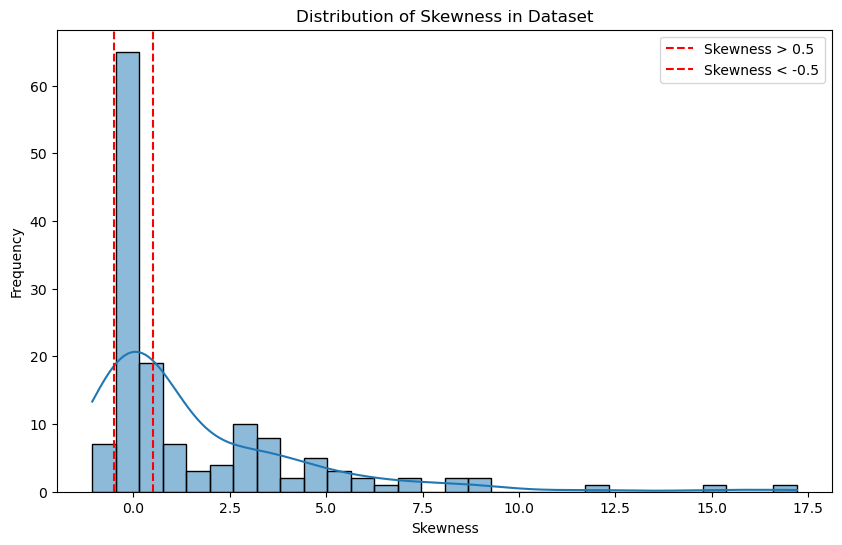

In [17]:
# Visualize the distribution of skewness values
plt.figure(figsize=(10, 6))
sns.histplot(skewness, bins=30, kde=True)
plt.axvline(x=0.5, color='r', linestyle='--', label='Skewness > 0.5')
plt.axvline(x=-0.5, color='r', linestyle='--', label='Skewness < -0.5')
plt.title('Distribution of Skewness in Dataset')
plt.xlabel('Skewness')
plt.ylabel('Frequency')
plt.legend()
plt.show()

This code snippet generates a histogram with a kernel density estimation (KDE) overlay for the skewness values, adding vertical lines to indicate the threshold for significant skewness (>0.5 or <-0.5).

**Observations:**

**1. For Return Prediction:**
The identified skewness and kurtosis suggest that <font color='red'>tree-based methods may be superior for predicting returns, as they can better handle the data's non-normal distribution.</font>

**2. For VaR Quantification:**
<font color='red'>The high kurtosis values bolster the case for employing EVT in VaR modeling,</font> as it's designed to capture tail behavior, providing a more accurate risk profile for assets prone to extreme fluctuations, like ETRN_close.


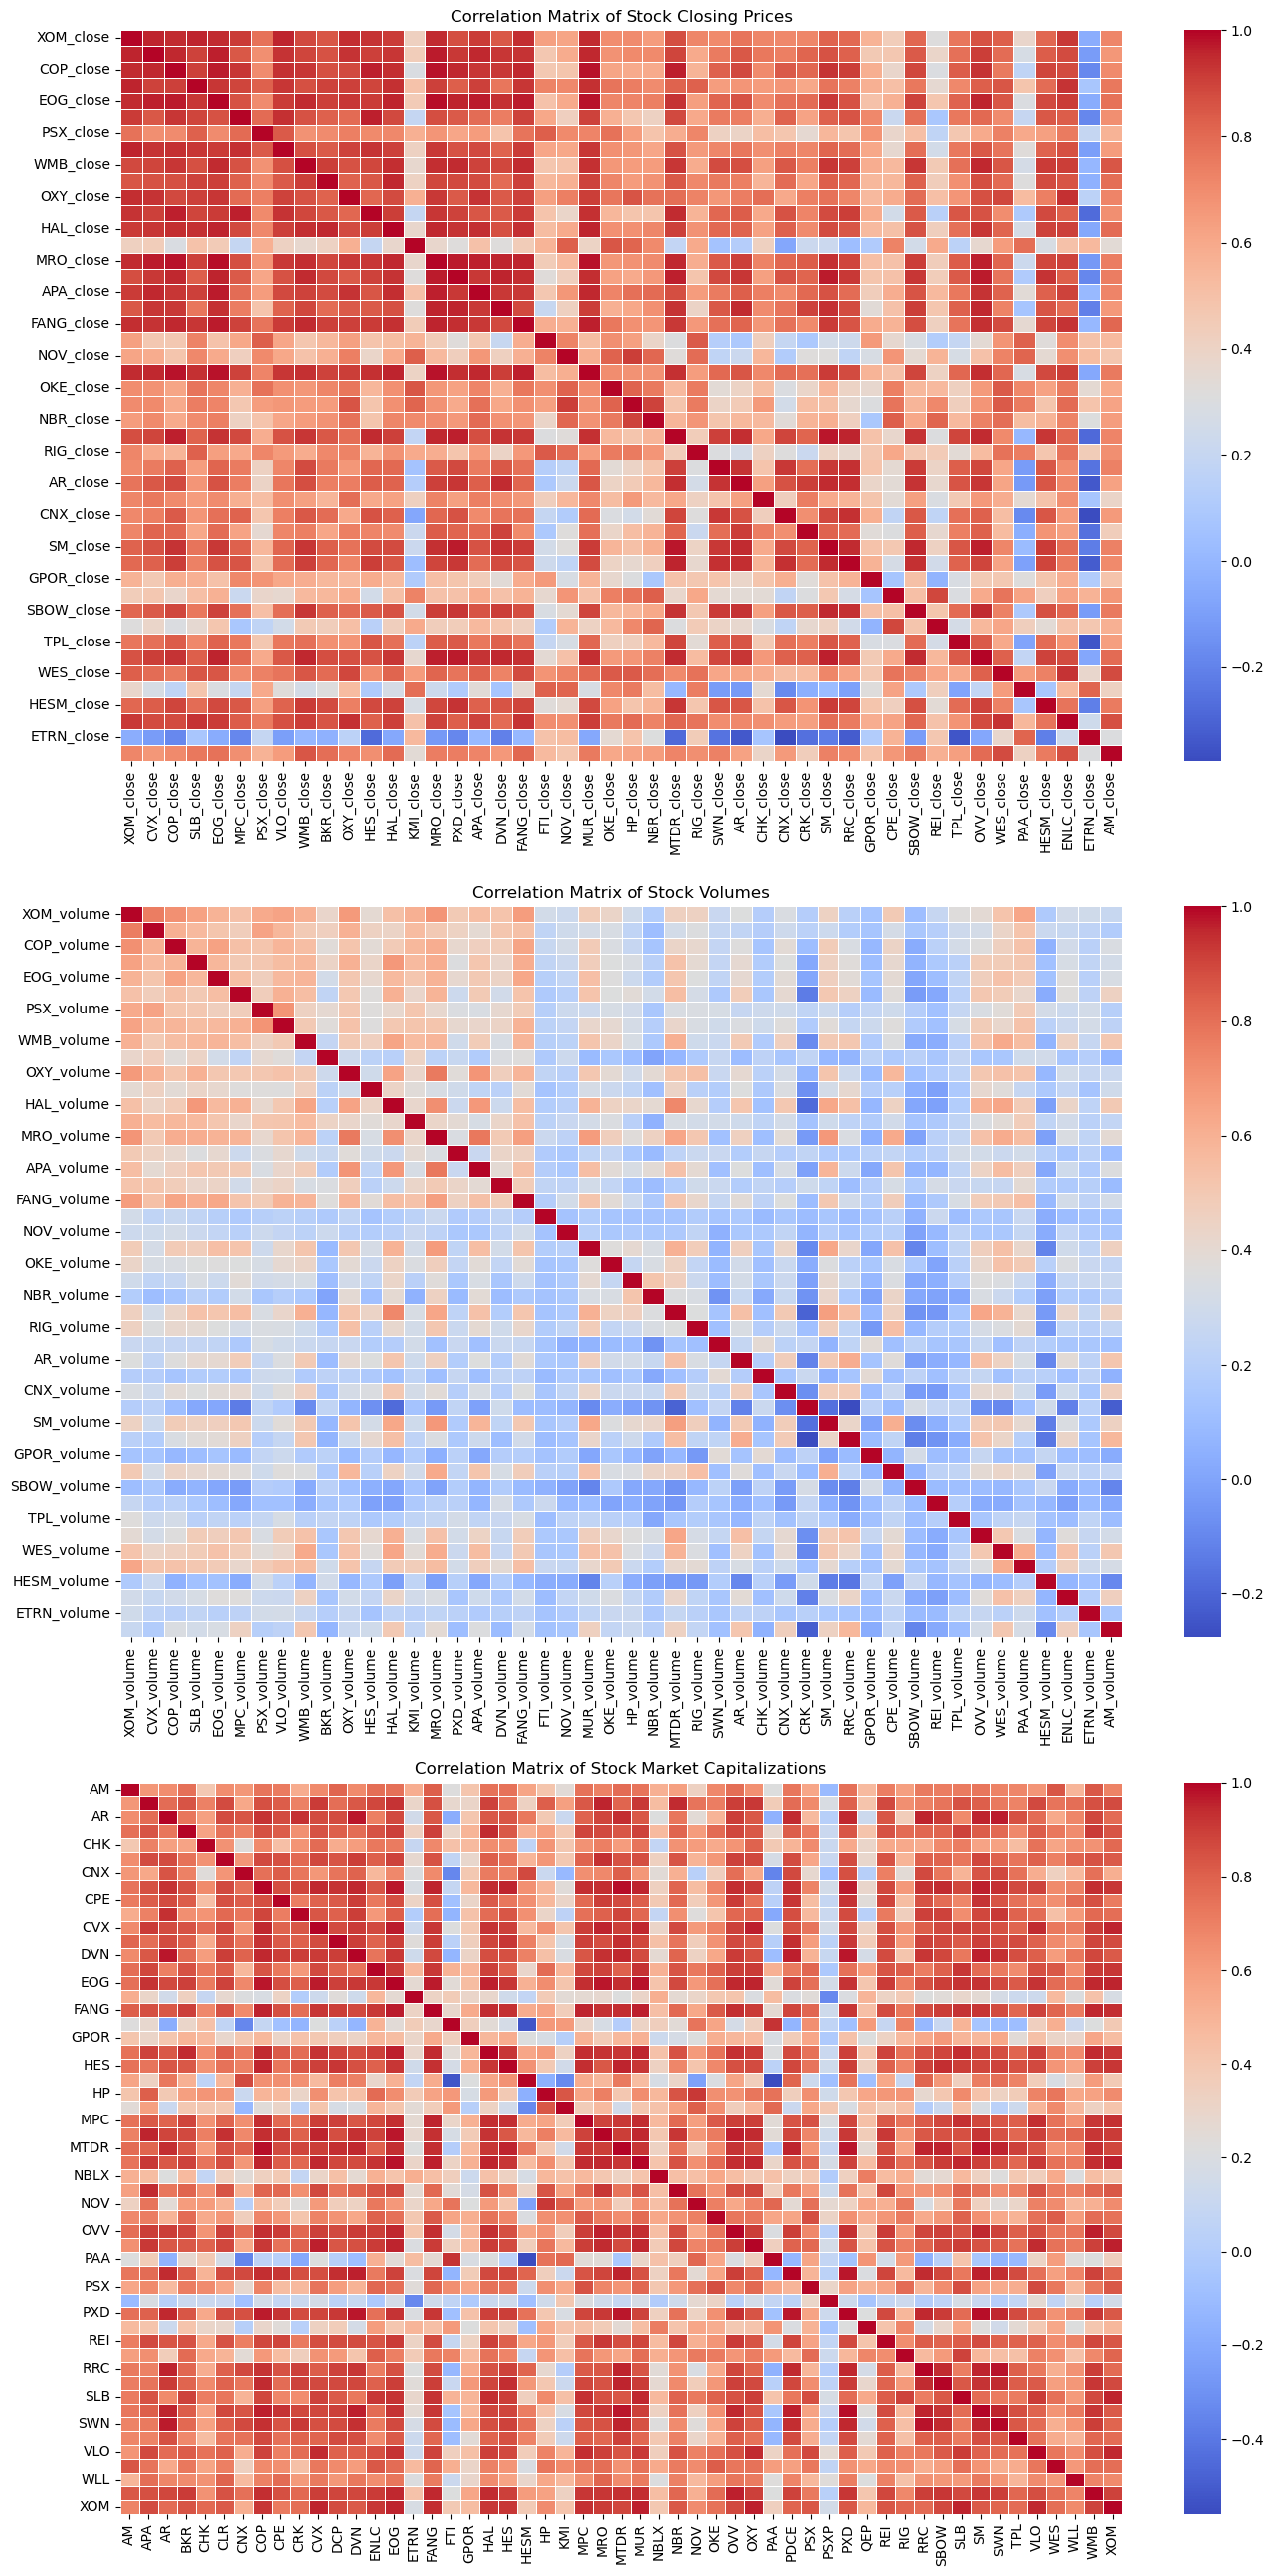

In [18]:
# Defining the subset for market capitalizations based on the actual dataset
# Identifying market cap columns as those without suffixes '_close' or '_volume'
market_cap_columns = [col for col in imputed_full_df.columns if not col.endswith(('_close', '_volume', 'Date', 'day_of_week', 'month', 'year'))]
close_columns = [col for col in imputed_full_df.columns if col.endswith(('_close'))]
volume_columns = [col for col in imputed_full_df.columns if col.endswith(('_volume'))]
selected_stocks_mcap = imputed_full_df[market_cap_columns]
selected_stocks_close = imputed_full_df[close_columns]
selected_stocks_volume = imputed_full_df[volume_columns]

# Calculating the correlation matrix for market capitalizations
correlation_matrix_mcap = selected_stocks_mcap.corr()
correlation_matrix_close = selected_stocks_close.corr()
correlation_matrix_volume = selected_stocks_volume.corr()

# Setting up the figure for three subplots to include market capitalizations
fig, axs = plt.subplots(3, 1, figsize=(14, 26))

# Plotting the correlation matrix for closing prices
sns.heatmap(correlation_matrix_close, ax=axs[0], annot=False, cmap='coolwarm', linewidths=.5)
axs[0].set_title('Correlation Matrix of Stock Closing Prices')

# Plotting the correlation matrix for volumes
sns.heatmap(correlation_matrix_volume, ax=axs[1], annot=False, cmap='coolwarm', linewidths=.5)
axs[1].set_title('Correlation Matrix of Stock Volumes')

# Plotting the correlation matrix for market capitalizations
sns.heatmap(correlation_matrix_mcap, ax=axs[2], annot=False, cmap='coolwarm', linewidths=.5)
axs[2].set_title('Correlation Matrix of Stock Market Capitalizations')

plt.tight_layout()
plt.show()

**Observations**:

**1. Diverse Investor Behavior and Liquidity Insights** suggest that the variability in volume correlations across stocks points to different levels of investor engagement and liquidity considerations. This can impact trading strategies and risk management, highlighting opportunities for arbitrage and the need for tailored execution strategies for large trades.

**2. Anomaly Detection** indicates that spotting unusual changes in volume correlation patterns can provide early signals for market events or shifts in investor sentiment, warranting further investigation.

**3. Strong Positive Correlations** across many stocks, particularly within sectors, reflect shared market influences or economic factors, guiding strategic investment decisions and highlighting the importance of understanding sectoral dynamics.

**4. Lack of Strong Negative Correlations** suggests limited opportunities for hedging within this set, emphasizing the need for diversification across different sectors or asset classes.


**Actionable Next Steps:**

**1.Principal Component Analysis (PCA)** to reduce dimensionality and uncover the principal components driving stock price movements, aiding in predictive modeling and market analysis.

**2. Vector Autoregression (VAR)** Model to capture the dynamic interdependencies among multiple time series, offering a robust framework for forecasting stock movements based on historical data.

**3. Granger Causality Tests** to explore predictive relationships between stocks, identifying potential leading indicators or causality in price movements.

**4. Dynamic Conditional Correlation (DCC) Models** to understand how correlations evolve over time, especially useful for managing portfolio risk and identifying diversification strategies during different market phases.
    

## 3 Feature Engineering

### 3.1 Adding Feature
#### 3.1.1 Main Feature
Adding feature is tricky, and we only always put the data that is relevant so that it can perform without unnecessary noise. With 3 main data type that we have (Close Price, Volume, and Market Cap). However, we will use only 1 primary for Fat Tail Risk Assessement, and will make the derivative from it. It is because of this reasons:

**1. Close Prices**
- Primary Use: Modeling price movements, calculating returns, and assessing risk.
- Relevance for Fat Tail Risk Assessment: High. Close prices are crucial because they are used to compute daily returns, which are the basis for most risk assessment models, including those analyzing fat tails. Returns (rather than prices themselves) are typically what you'd model using EVT and calculate VaR (Value at Risk) and ES (Expected Shortfall) on.

**2. Volume**
- Primary Use: Indicating the liquidity and activity level of a market or security.
- Relevance for Fat Tail Risk Assessment: Moderate to Low. Volume can provide context about market conditions (e.g., high volume might accompany significant price moves), but it's not directly used in fat tail risk modeling. It could, however, offer auxiliary insights into market behavior during extreme events.

**3. Market Cap**
- Primary Use: Reflecting the size and stability perception of a company.
- Relevance for Fat Tail Risk Assessment: Low. Market cap is more about the company's valuation and size than about its risk profile from a market dynamics perspective. It's not typically used in statistical risk models but can be relevant for portfolio construction and diversification strategies.

However, for return prediction, we will use overall


In [19]:
df = imputed_full_df  

# Convert Date Column : ensure your 'date' column is in datetime format to easily extract date components.
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

#### 3.1.2 Date Components for Feature Engineering:
1. Day of the Week: Different days might exhibit varying trading behaviors.
2. Month: To capture potential monthly seasonality effects.
3. Year: For capturing long-term trends.
4. Holiday Effects: Days before or after holidays might show different patterns => this is not in our current analysis, but it might be helpfull for further analysis

These components can be derived from the date and used as additional features. Yet, it's crucial to assess their actual predictive value for your specific forecasting task.

In [20]:
# Date Components
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year
print(df.columns)

Index(['XOM_close', 'CVX_close', 'COP_close', 'SLB_close', 'EOG_close',
       'MPC_close', 'PSX_close', 'VLO_close', 'WMB_close', 'BKR_close',
       ...
       'OVV_volume', 'WES_volume', 'PAA_volume', 'HESM_volume', 'ENLC_volume',
       'ETRN_volume', 'AM_volume', 'day_of_week', 'month', 'year'],
      dtype='object', length=148)


#### 3.1.3 Closing Price Feature Engineering

1. Daily Returns: The percentage change in closing prices from one day to the next.
2. Volatility Measures (30-day standard deviation of daily returns): Indicating the risk or uncertainty about the size of changes in an asset's value.
3. Skewness (30-day): Measuring the asymmetry of the return distribution, helping identify assets with potential for extreme losses or gains.
4. Kurtosis (30-day): Assessing the tail heaviness of the return distribution, which is crucial for understanding the risk of extreme price movements.
5. Lagged Returns (1-day lag): Showing previous day's returns, useful for identifying momentum or reversal patterns.
6. MACD (Moving Average Convergence Divergence): A trend-following momentum indicator that shows the relationship between two moving averages of the asset's price.
7. RSI (Relative Strength Index): Measuring the magnitude of recent price changes to evaluate overbought or oversold conditions.

In [21]:
# First, sort the DataFrame by 'Date'
df = df.sort_values('Date')

# Create a list to hold all new DataFrames created from feature engineering
feature_dfs = []

# Daily Returns, Volatility, Skewness, Kurtosis, and Lagged Returns
for col in close_columns:
    # Calculate all features and store them as separate Series/DataFrames
    daily_return = df[col].pct_change().rename(f'{col}_daily_return')
    volatility_30 = daily_return.rolling(window=30).std().rename(f'{col}_volatility_30')
    skewness_30 = daily_return.rolling(window=30).skew().rename(f'{col}_skewness_30')
    kurtosis_30 = daily_return.rolling(window=30).kurt().rename(f'{col}_kurtosis_30')
    lag1 = daily_return.shift(1).rename(f'{col}_lag1')
    lag5 = daily_return.shift(5).rename(f'{col}_lag5')
    
    # Add the new Series to the list as DataFrames
    feature_dfs.extend([daily_return, volatility_30, skewness_30, kurtosis_30, lag1, lag5])

# Financial Indicators: MACD and RSI
for col in close_columns:
    # Calculate MACD and RSI, and add them to the list
    ema_12 = df[col].ewm(span=12, adjust=False).mean()
    ema_26 = df[col].ewm(span=26, adjust=False).mean()
    MACD = (ema_12 - ema_26).rename(f'{col}_MACD')
    feature_dfs.append(MACD)
    
    delta = df[col].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    RSI = (100 - (100 / (1 + RS))).rename(f'{col}_RSI')
    feature_dfs.append(RSI)

# Concatenate all the new feature DataFrames with the original DataFrame
df = pd.concat([df] + feature_dfs, axis=1)

# Drop NA values resulting from rolling and shifting operations
df.dropna(inplace=True)

# Save the engineered features to a new CSV file
df.to_csv('testing_Feature_Engineered.csv')

# Display the head of the modified DataFrame for verification
print(df.head())

            XOM_close   CVX_close  COP_close  SLB_close   EOG_close  \
Date                                                                  
2019-04-23  83.379997  122.019997  66.449997  45.889999  106.599998   
2019-04-24  81.760002  118.279999  64.699997  44.240002  103.940002   
2019-04-25  82.220001  117.900002  63.970001  43.299999  102.080002   
2019-04-26  80.489998  117.099998  62.779999  43.299999   97.879997   
2019-04-29  79.970001  117.720001  62.650002  43.430000   97.000000   

            MPC_close  PSX_close  VLO_close  WMB_close  BKR_close  ...  \
Date                                                               ...   
2019-04-23  61.060001  97.400002  90.279999  28.820000  25.969999  ...   
2019-04-24  59.500000  94.279999  87.730003  28.680000  25.610001  ...   
2019-04-25  60.650002  95.220001  90.830002  28.469999  25.570000  ...   
2019-04-26  60.389999  94.919998  90.080002  28.490000  25.580000  ...   
2019-04-29  60.990002  95.360001  89.599998  28.290001  25

In [22]:
# Create a list to hold all new Series created from feature engineering
feature_series = []

# Feature Engineering for Volume Data
for col in volume_columns:
    # Calculate volume oscillation and volume shock, and store as separate Series
    volume_oscillation = (df[col].rolling(window=7).mean() - df[col].rolling(window=28).mean()).rename(f'{col}_oscillation')
    volume_shock = (df[col].pct_change().abs() > 0.1).astype(int).rename(f'{col}_shock')
    
    # Add the new Series to the list
    feature_series.append(volume_oscillation)
    feature_series.append(volume_shock)

# Feature Engineering for Market Cap Data
for col in market_cap_columns:
    # Calculate market cap momentum, and store as separate Series
    market_cap_momentum = (df[col] - df[col].rolling(window=30).mean()).rename(f'{col}_momentum')
    feature_series.append(market_cap_momentum)

# Concatenate all the new feature Series with the original DataFrame
df = pd.concat([df] + feature_series, axis=1)

# Drop NA values resulting from rolling operations
df.dropna(inplace=True)

# Optionally, save the engineered features to a new CSV file
df.to_csv('enhanced_feature_engineered.csv')

# Display the head of the modified DataFrame for verification
print(df.head())

            XOM_close   CVX_close  COP_close  SLB_close  EOG_close  MPC_close  \
Date                                                                            
2019-06-04  73.589996  117.300003  59.099998  35.730000  84.279999  48.490002   
2019-06-05  72.980003  117.650002  57.080002  34.939999  82.029999  47.689999   
2019-06-06  74.309998  120.680000  58.200001  35.049999  84.269997  48.099998   
2019-06-07  74.580002  121.480003  58.959999  35.599998  84.599998  46.990002   
2019-06-10  74.910004  122.290001  59.259998  35.470001  85.199997  47.680000   

            PSX_close  VLO_close  WMB_close  BKR_close  ...  SBOW_momentum  \
Date                                                    ...                  
2019-06-04  84.120003  73.849998  27.690001  22.040001  ...     -19.090000   
2019-06-05  84.830002  73.139999  27.850000  22.230000  ...     -26.343333   
2019-06-06  84.900002  74.470001  27.549999  22.950001  ...     -30.403333   
2019-06-07  85.519997  74.730003  27.76000

### 3.2 Normalization / Standardization

Despite that our VaR model will keep the model as it is to mitigate from loss information of normalisation that might occurs, we still need to do normalization for the data, especially we are aiming to do dimentional reduction with our huge data. Hence, at least a sufficient normalization is needed for this model, although we are planning to use tree-based models or other non-parametric models that are robust to non-normal distributions. 

In [23]:
# Checking for constant columns
constant_columns = [col for col in df.columns if df[col].nunique() <= 1]
print("Columns with constant values (which may not be suitable for Shapiro-Wilk):", constant_columns)

Columns with constant values (which may not be suitable for Shapiro-Wilk): []


In [26]:
# Define multiple preprocessing pipelines including the new one
pipelines = {
    'power_transform_and_robust_scale': Pipeline([
        ('power_transform', PowerTransformer(method='yeo-johnson', standardize=False)),
        ('robust_scaler', RobustScaler())
    ]),
    'quantile_transform_normal': Pipeline([
        ('quantile_transform', QuantileTransformer(output_distribution='normal', n_quantiles=10))
    ]),
    'standard_scale': StandardScaler(),
    'power_transform_and_min_max_scale': Pipeline([
        ('power_transform', PowerTransformer()),
        ('min_max_scaler', MinMaxScaler())
    ])
    # Add more transformations as needed
}

# Function to perform Shapiro-Wilk test on all features
def perform_shapiro_wilk_test(data, features):
    results = {}
    for feature in features:
        stat, p_value = shapiro(data[feature])
        results[feature] = p_value
    # Calculate the average p-value across features for an overall score
    avg_p_value = sum(results.values()) / len(results)
    return avg_p_value

# Exclude non-numeric columns like 'date' if present
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df[numeric_cols]

# Evaluate each pipeline
evaluation_results = {}
for name, pipeline in pipelines.items():
    # Transform the data using the current pipeline
    df_transformed = pipeline.fit_transform(df_numeric)
    df_transformed = pd.DataFrame(df_transformed, columns=numeric_cols)
    
    # Perform Shapiro-Wilk test after preprocessing and get the average p-value
    avg_p_value = perform_shapiro_wilk_test(df_transformed, numeric_cols)
    
    # Store the average p-value as the score for the pipeline
    evaluation_results[name] = avg_p_value

# Display the evaluation results
for pipeline, avg_p in evaluation_results.items():
    print(f"Pipeline: {pipeline}, Average P-Value: {avg_p}")

# Determine the best pipeline based on the highest average p-value
best_pipeline = max(evaluation_results, key=evaluation_results.get)
print(f"The best pipeline based on the Shapiro-Wilk test is: {best_pipeline}")

Pipeline: power_transform_and_robust_scale, Average P-Value: 0.00876150091919999
Pipeline: quantile_transform_normal, Average P-Value: 1.1226101282942694e-07
Pipeline: standard_scale, Average P-Value: 0.0016130948037463557
Pipeline: power_transform_and_min_max_scale, Average P-Value: 0.008761890435774845
The best pipeline based on the Shapiro-Wilk test is: power_transform_and_min_max_scale


In [27]:
# Assuming df_numeric contains your numeric features as defined previously

# Define the "power_transform_and_min_max_scale_scale" pipeline
power_transform_and_min_max_scale_pipeline = Pipeline([
        ('power_transform', PowerTransformer()),
        ('min_max_scaler', MinMaxScaler())
])

# Fit and transform the data using the pipeline
df_transformed = power_transform_and_min_max_scale_pipeline.fit_transform(df_numeric)

# Convert the transformed data back to a DataFrame
# Ensure to use the same column names as in df_numeric
df_standardized = pd.DataFrame(df_transformed, columns=df_numeric.columns)

### 3.2 Stationarity Check

Despite we are dealing with time series data, our prediction is short term (DoD). And since we are planning to use tree-based models that are applied to time-series data for forecasting, they can handle non-stationarity by including lagged terms and other engineered features that capture temporal dynamics. These models do not require the data to be stationary because they do not rely on the data having constant statistical properties over time.

Hence, any small error of the data that is not comply with stationarity will be ok for our overall data. Here, we want to check the stationarity of our overall data.

In [28]:
# Convert the NumPy array back to a pandas DataFrame, with the correct column names
df_standardized = pd.DataFrame(df_standardized, columns=numeric_cols)

# Function to apply the ADF test across all numeric columns and store results
def apply_adf_test(df):
    adf_results = {}
    for col in df.columns:
        result = adfuller(df[col].dropna())
        adf_results[col] = {'Test Statistic': result[0], 'p-value': result[1]}
    return adf_results

# Apply the ADF test
adf_test_results = apply_adf_test(df_standardized)

# Convert the results to a DataFrame for easier analysis
adf_results_df = pd.DataFrame(adf_test_results).T

# Display the ADF test results
print(adf_results_df)

# Identifying columns with p-values greater than the typical alpha level of 0.05, indicating non-stationarity
non_stationary_columns = adf_results_df[adf_results_df['p-value'] > 0.05].index.tolist()
print("Non-stationary Columns:", non_stationary_columns)

# Assuming 'df_numeric' is your DataFrame of numeric features
normality_results = {}
for column in df_numeric.columns:
    stat, p = shapiro(df_numeric[column])
    normality_results[column] = {'statistic': stat, 'p-value': p}


              Test Statistic       p-value
XOM_close          -0.644779  8.605396e-01
CVX_close          -1.359303  6.016238e-01
COP_close          -0.989868  7.569417e-01
SLB_close          -1.163966  6.889013e-01
EOG_close          -1.254767  6.496041e-01
...                      ...           ...
VLO_momentum       -5.486053  2.228726e-06
WES_momentum       -6.042068  1.338617e-07
WLL_momentum       -9.325611  9.629215e-16
WMB_momentum       -5.667829  9.065601e-07
XOM_momentum       -5.868691  3.279015e-07

[658 rows x 2 columns]
Non-stationary Columns: ['XOM_close', 'CVX_close', 'COP_close', 'SLB_close', 'EOG_close', 'MPC_close', 'PSX_close', 'VLO_close', 'WMB_close', 'BKR_close', 'OXY_close', 'HES_close', 'HAL_close', 'MRO_close', 'PXD_close', 'APA_close', 'DVN_close', 'FANG_close', 'FTI_close', 'NOV_close', 'MUR_close', 'OKE_close', 'HP_close', 'NBR_close', 'MTDR_close', 'RIG_close', 'SWN_close', 'AR_close', 'CHK_close', 'CNX_close', 'CRK_close', 'SM_close', 'RRC_close', 'GPOR_c

If we visualize the feature stationarity, we can get:

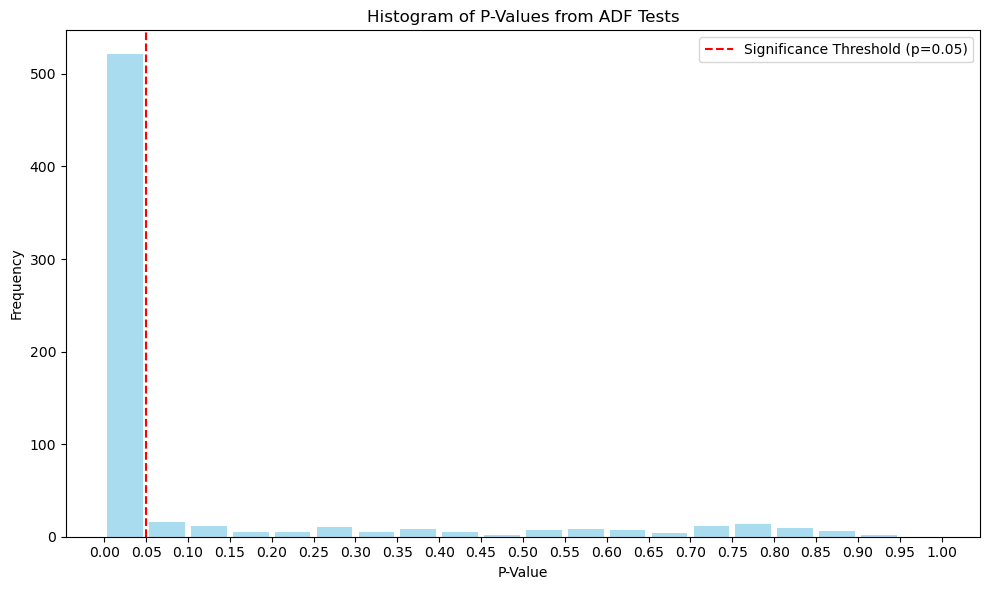

In [29]:
# Generate p values
p_values = adf_results_df['p-value']  

# Create the histogram with the p-values
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(p_values, bins=np.linspace(0, 1, 21), color='skyblue', alpha=0.7, rwidth=0.85)

# Adding the significance threshold line
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')

# Adding labels and title
plt.title('Histogram of P-Values from ADF Tests')
plt.xlabel('P-Value')
plt.ylabel('Frequency')
plt.xticks(np.linspace(0, 1, 21))  # Setting x-ticks to match the bins for clarity
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

Based on histogram, it appears that the majority of your features have p-values less than 0.05, as indicated by the concentration of bars to the left of the red dashed threshold line. In the context of the Augmented Dickey-Fuller (ADF) test, this suggests that most of your data is stationary, meaning that it does not have a unit root, and the time series has constant mean and variance over time.

Since most of the features are stationary, traditional time series models that assume stationarity, like ARIMA, can be used. However, here, we might use machine learning models that do not solely require this assumption

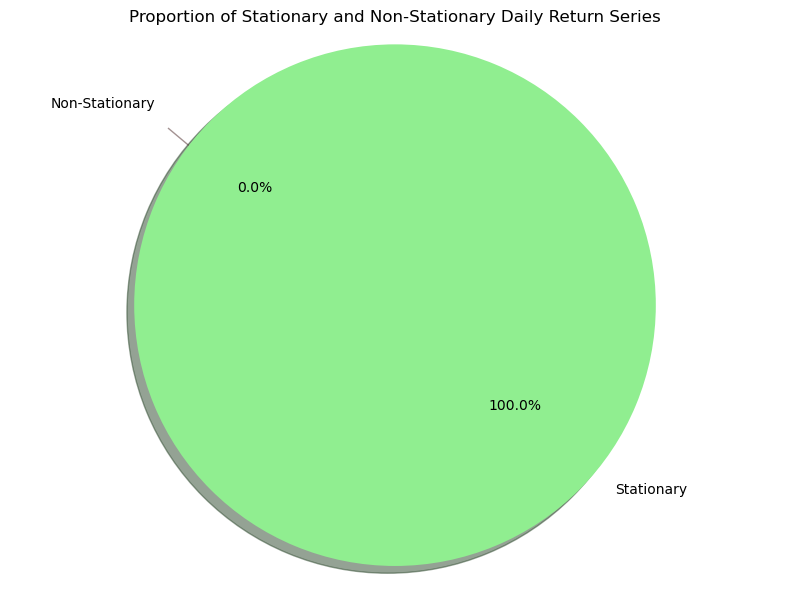

In [30]:
# Assuming `data` is your DataFrame and it includes "_daily_return" columns
# Filter columns that end with '_daily_return'
daily_return_columns = [col for col in df.columns if col.endswith('_daily_return')]

# Define a function to perform the ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return {
        "ADF Statistic": result[0],
        "p-value": result[1],
        "Critical Values": result[4],
        "Is Stationary": result[1] < 0.05
    }

# Apply the ADF test to each '_daily_return' column and collect the results
adf_results = {col: adf_test(df[col].dropna()) for col in daily_return_columns}

# Prepare data for the pie chart
stationary_count = sum(result['Is Stationary'] for result in adf_results.values())
non_stationary_count = len(adf_results) - stationary_count

# Data for the pie chart
sizes = [stationary_count, non_stationary_count]
labels = ['Stationary', 'Non-Stationary']
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # explode the 1st slice

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Proportion of Stationary and Non-Stationary Daily Return Series')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

PCA should be applied after standardization, as it is sensitive to the variances of the input variables. And since our data is quite a lot due to feature enchanment; let we see the correlation and see if that many of your features are correlated or if model complexity becomes a computational burden.

### 3.3 Dimention Reduction
#### 3.3.1 Return Prediction Model

**1. Pre-process for PCA:**
   - standardize the feature data but not for the output.
   - Exclude the Target Columns Before PCA. 
   This way, the target(s) are preserved in their original form for training and evaluating your models.
   
**2. Perform PCA:**
Initialize PCA and fit it on your standardized data to reduce dimensionality while retaining 95% of the variance.

**3. Create a Scree Plot:**
After fitting PCA, create a scree plot to visualize the cumulative explained variance. This helps you understand how many components you're using to capture the variance.

**4. Summarize PCA Results:**
Print out the original and reduced dimensionality along with the percentage of variance retained.


In [31]:
# # # Split Features and Targets:

# Features would exclude the daily_return columns
feature_columns = [col for col in df.columns if not col.endswith('daily_return')]
X = df[feature_columns]
print(X)

# Targets would be just the daily_return columns
target_columns = [col for col in df.columns if col.endswith('daily_return')]
Y = df[target_columns]
print(X.columns)
print(Y.columns)
# print(Y)

             XOM_close   CVX_close   COP_close  SLB_close   EOG_close  \
Date                                                                    
2019-06-04   73.589996  117.300003   59.099998  35.730000   84.279999   
2019-06-05   72.980003  117.650002   57.080002  34.939999   82.029999   
2019-06-06   74.309998  120.680000   58.200001  35.049999   84.269997   
2019-06-07   74.580002  121.480003   58.959999  35.599998   84.599998   
2019-06-10   74.910004  122.290001   59.259998  35.470001   85.199997   
...                ...         ...         ...        ...         ...   
2024-03-04  104.360001  148.880005  111.639999  49.419998  115.830002   
2024-03-05  105.639999  149.589996  111.220001  49.660000  116.199997   
2024-03-06  106.769997  148.330002  111.989998  50.029999  116.489998   
2024-03-07  107.370003  149.369995  112.739998  50.779999  117.849998   
2024-03-08  108.379997  149.880005  113.000000  50.400002  118.720001   

             MPC_close   PSX_close   VLO_close  WM

With 470 object; it will be hard to do analysis if some of the data will just be noise. Hence, we will try to check with PCA - Principal Component Analysis (PCA) Scree Plot

In [32]:
# Standardize the features (not the target variables)
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Convert the NumPy array back to a pandas DataFrame, including column names
X_standardized_df = pd.DataFrame(X_standardized, columns=X.columns)

# Now you can safely print the columns
print(X_standardized_df.columns)

Index(['XOM_close', 'CVX_close', 'COP_close', 'SLB_close', 'EOG_close',
       'MPC_close', 'PSX_close', 'VLO_close', 'WMB_close', 'BKR_close',
       ...
       'SBOW_momentum', 'SLB_momentum', 'SM_momentum', 'SWN_momentum',
       'TPL_momentum', 'VLO_momentum', 'WES_momentum', 'WLL_momentum',
       'WMB_momentum', 'XOM_momentum'],
      dtype='object', length=615)


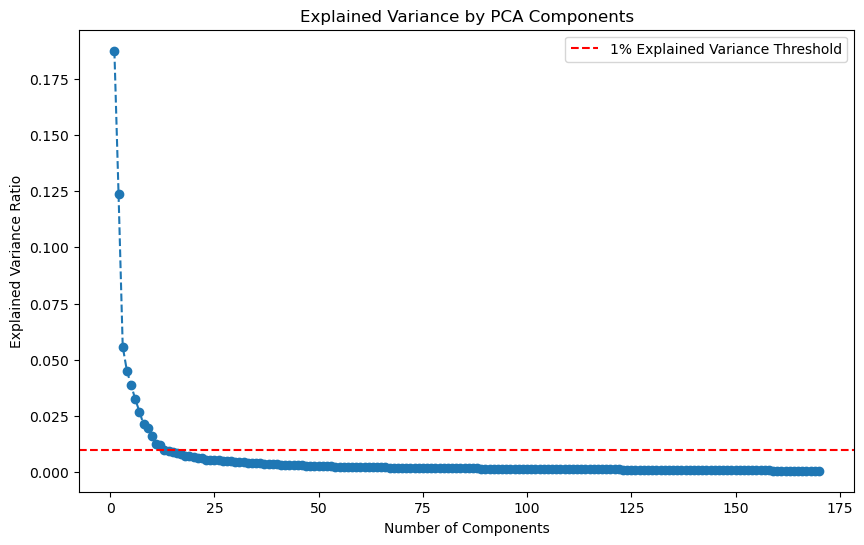

From PCA, we can reduce from 615 to 170 dimensions while retaining 95% of the total variance.


In [33]:
# Assuming 'X_standardized' is a standardized features numpy array and is already defined
original_dimensionality = X_standardized.shape[1]  # This is the total number of original features

# Perform PCA on the features only
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_standardized)

# The number of components that PCA used to explain 95% of the variance
reduced_dimensionality = pca.n_components_
explained_variance = pca.explained_variance_ratio_

# Plotting the Explained Variance by PCA Components
plt.figure(figsize=(10, 6))
plt.plot(range(1, reduced_dimensionality + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.axhline(y=0.01, color='r', linestyle='--', label='1% Explained Variance Threshold')
plt.legend()
plt.show()

# Output the result of the dimensionality reduction
print(f"From PCA, we can reduce from {original_dimensionality} to {reduced_dimensionality} "
      f"dimensions while retaining 95% of the total variance.")


In [34]:

# Convert the PCA components into a DataFrame for easier analysis
X_pca_df = pd.DataFrame(X_pca)

# Calculate the correlation matrix for the PCA components
pca_corr_matrix = X_pca_df.corr()

# Identify any significant correlations between components (off-diagonal elements)
# Here we are interested in correlations greater than 0.8 or less than -0.8
significant_corrs = np.where((np.abs(pca_corr_matrix) > 0.8) & (np.abs(pca_corr_matrix) < 1))
significant_corrs = [(pca_corr_matrix.index[x], pca_corr_matrix.columns[y]) for x, y in zip(*significant_corrs)]

# Output the significant correlations, if any
if significant_corrs:
    print("Significant correlations found between PCA components:", significant_corrs)
else:
    print("No significant correlations found between PCA components. PCA is effective.")

No significant correlations found between PCA components. PCA is effective.


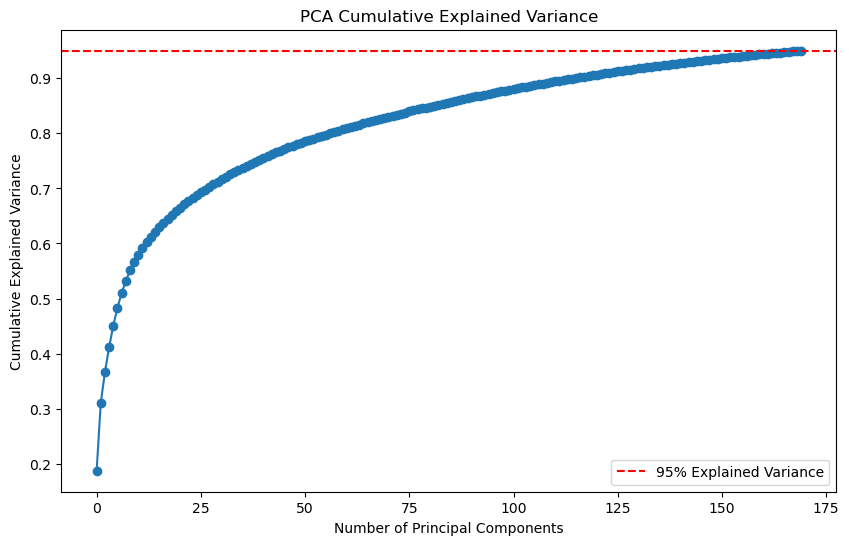

From PCA, we can reduce 615 to 170 dimensions while retaining 95% of the total variance.


In [35]:
# Scree Plot
plt.figure(figsize=(10, 6))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()

# Summary of PCA results
original_dimensionality = X.shape[1]
print(f"From PCA, we can reduce {original_dimensionality} to {reduced_dimensionality} "
      f"dimensions while retaining 95% of the total variance.")


#### 3.3.2 VaR CVaR Quantification - Feature Categories

In [36]:
# Extend the feature categories to include all relevant types
feature_categories = {
    'daily_return': [col for col in df.columns if 'daily_return' in col],
    'volatility_30': [col for col in df.columns if 'volatility_30' in col],
    'MACD': [col for col in df.columns if '_MACD' in col],
    'RSI': [col for col in df.columns if '_RSI' in col],
    'skewness_30': [col for col in df.columns if 'skewness_30' in col],
    'kurtosis_30': [col for col in df.columns if 'kurtosis_30' in col],
}

# Initialize a DataFrame for aggregated category means
category_means = pd.DataFrame(index=df.index)

# Calculate the mean for each category across all corresponding features
for category, columns in feature_categories.items():
    if columns:  # Ensure there are columns for this category
        category_means[f'{category}_mean'] = df[columns].mean(axis=1)

# Perform variance analysis on these category means
extended_category_variances = category_means.var().sort_values(ascending=False)

print(extended_category_variances)

RSI_mean              169.431852
MACD_mean               3.661325
kurtosis_30_mean        0.829084
skewness_30_mean        0.113819
daily_return_mean       0.000835
volatility_30_mean      0.000299
dtype: float64


Traditional Value at Risk (VaR) and Conditional Value at Risk (CVaR) methodologies, with their reliance on normal distribution assumptions, often underestimate the risks of extreme market events, potentially skewing risk estimates due to a heightened sensitivity to outliers. In contrast, methods based on Extreme Value Theory (EVT) and the Generalized Pareto Distribution (GPD) are meticulously designed to offer more accurate tail risk assessments and improved sensitivity to extreme events by tailoring their approach to fat-tailed distributions. This not only ensures a more realistic evaluation of financial risks but also aligns more closely with regulatory standards for stress testing and risk management. By providing a robust framework that captures the essence of market volatility and the likelihood of rare but impactful events, EVT/GPD-based methodologies enhance compliance and bolster risk management strategies, making them invaluable for navigating the complexities of financial markets.

##  Calculate DoD Returns

### Preparing the Training and Testing Sets


When dealing with time series data, such as stock returns, it is crucial to split the data in a chronological order rather than randomly, to avoid lookahead bias, where the model inadvertently learns from future data.

Here's a code template for splitting your PCA-transformed features (X_pca) and target variables (Y):

In [37]:
# Assuming X_pca and Y are already defined
train_size = int(len(X_pca) * 0.8)
X_train, X_test = X_pca[:train_size], X_pca[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

assert len(X_train) == len(y_train), "Length mismatch between X_train and y_train"
assert len(X_test) == len(y_test), "Length mismatch between X_test and y_test"

### Hyperparameter Distributions Setup

In [35]:

# Reduce the number of jobs for preliminary screening
n_jobs_reduced = 4  # Adjust based on your system's capabilities


param_dists = {
    "Random Forest": {
        'estimator__n_estimators': randint(100, 500),
        'estimator__max_depth': [None, 10, 20, 30],
        # ... other RandomForestRegressor parameters
    },
    "Gradient Boosting": {
        'estimator__n_estimators': randint(50, 300),
        # ... other GradientBoostingRegressor parameters
    },
    "SVR": {
        'estimator__C': uniform(0.1, 10),
        # ... other SVR parameters
    },
    "XGBoost": {
        'estimator__n_estimators': randint(50, 300),
        'estimator__learning_rate': uniform(0.01, 0.3),
        # ... other XGBRegressor parameters
    }
}

### Part 1: Preliminary Screening Code - Optuna
The goal here is to quickly identify which models and range of hyperparameters show promise. This involves running a RandomizedSearchCV with reduced hyperparameter spaces and fewer iterations.

Approach 1: Using Optuna for Automated Model and Hyperparameter Selection
Advantages:

Integrated Model and Hyperparameter Space: Optuna allows you to define both the model and its hyperparameters within the same trial, making the search more seamless and integrated.
Efficiency: Optuna uses Bayesian optimization (among other strategies), which can be more efficient than random search, especially in finding optimal hyperparameters faster.
Pruning: Optuna has the capability to stop unpromising trials early, which can significantly reduce computation time.
Flexibility: This method offers high flexibility in defining complex hyperparameter spaces, including conditional hyperparameters (where the presence of a hyperparameter depends on another’s value).
Drawbacks:

Complexity in Setup: The setup might initially seem more complex due to the need to define everything within the objective function.
Learning Curve: There's a slight learning curve to using Optuna effectively, especially for complex search spaces or custom trial pruning strategies.


In [70]:
import optuna
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

# Assume X_train, y_train are defined
# y_train is a DataFrame where each column is a different output to be predicted

def create_model(classifier_name, params):
    # Prepare the parameters by removing the prefix and adjusting parameter names as necessary
    if classifier_name == 'Lasso':
        # For Lasso, remove the 'lasso_' prefix
        cleaned_params = {k.replace('lasso_', ''): v for k, v in params.items()}
        return Lasso(**cleaned_params)
    elif classifier_name == 'ElasticNet':
        # For ElasticNet, remove the 'enet_' prefix
        cleaned_params = {k.replace('enet_', ''): v for k, v in params.items()}
        return ElasticNet(**cleaned_params)
    elif classifier_name == 'KNN':
        # For KNN, remove the 'knn_' prefix
        cleaned_params = {k.replace('knn_', ''): v for k, v in params.items()}
        return KNeighborsRegressor(**cleaned_params)


def objective(trial, y_col):
    classifier_name = trial.suggest_categorical('classifier', ['Lasso', 'ElasticNet', 'KNN'])
    model = None
    
    if classifier_name == 'Lasso':
        alpha = trial.suggest_float('lasso_alpha', 1e-4, 1.0, log=True)
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', Lasso(alpha=alpha, max_iter=10000, random_state=42))
        ])
    
    elif classifier_name == 'ElasticNet':
        alpha = trial.suggest_float('enet_alpha', 1e-4, 1.0, log=True)
        l1_ratio = trial.suggest_float('enet_l1_ratio', 0.0, 1.0)
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, random_state=42))
        ])
    
    elif classifier_name == 'KNN':
        n_neighbors = trial.suggest_int('knn_n_neighbors', 1, 30)
        model = KNeighborsRegressor(n_neighbors=n_neighbors)
    
    scores = cross_val_score(model, X_train, y_train.iloc[:, y_col], cv=5, scoring=make_scorer(r2_score))
    return np.mean(scores)

# Store the best trial for each output column
best_trials = {}

# Perform a separate Optuna study for each output column in y_train
for i in range(y_train.shape[1]):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, i), n_trials=30)
    
    # Correctly retrieve the best_trial from the study
    best_trial = study.best_trial
    
    # Store classifier name and parameters correctly
    best_trials[i] = {
        'classifier': best_trial.params['classifier'],
        'params': {k: v for k, v in best_trial.params.items() if k != 'classifier'}
    }

# Correctly use the stored information
for i in range(y_train.shape[1]):
    # Directly access 'classifier' and 'params' from best_trials
    classifier_name = best_trials[i]['classifier']
    best_params = best_trials[i]['params']
    
    # Create and fit the model
    best_model = create_model(classifier_name, best_params)
    best_model.fit(X_train, y_train.iloc[:, i])
    
    # Predict and evaluate
    predictions = best_model.predict(X_test)
    actual = y_test.iloc[:, i]
    r2 = r2_score(actual, predictions)
    
    # Output performance
    print(f"Column {i}: Best {classifier_name} model with params {best_params}")
    print(f"Column {i} R2 score: {r2}\n")

[I 2024-04-07 11:38:43,043] A new study created in memory with name: no-name-058fee7e-724b-4975-8ec4-ce3d7e39f9fc
[I 2024-04-07 11:38:43,380] Trial 0 finished with value: 0.027388716650274626 and parameters: {'classifier': 'ElasticNet', 'enet_alpha': 0.0066097956012042885, 'enet_l1_ratio': 0.4499657097586761}. Best is trial 0 with value: 0.027388716650274626.
[I 2024-04-07 11:38:43,534] Trial 1 finished with value: -0.012667581435525576 and parameters: {'classifier': 'Lasso', 'lasso_alpha': 0.011396827035393792}. Best is trial 0 with value: 0.027388716650274626.
[I 2024-04-07 11:38:43,678] Trial 2 finished with value: -0.012667581435525576 and parameters: {'classifier': 'ElasticNet', 'enet_alpha': 0.3661791700485033, 'enet_l1_ratio': 0.42116561440231415}. Best is trial 0 with value: 0.027388716650274626.
[I 2024-04-07 11:38:43,804] Trial 3 finished with value: -0.012667581435525576 and parameters: {'classifier': 'Lasso', 'lasso_alpha': 0.04706256453423013}. Best is trial 0 with value: 

Column 0: Best KNN model with params {'knn_n_neighbors': 25}
Column 0 R2 score: 0.07833209056279178

Column 1: Best KNN model with params {'knn_n_neighbors': 14}
Column 1 R2 score: -0.03738622609888176

Column 2: Best ElasticNet model with params {'enet_alpha': 0.013054847114251191, 'enet_l1_ratio': 0.06521299427050065}
Column 2 R2 score: -0.48430862864359425

Column 3: Best ElasticNet model with params {'enet_alpha': 0.0036759513558799165, 'enet_l1_ratio': 0.5853848387283034}
Column 3 R2 score: 0.12167632111813997

Column 4: Best ElasticNet model with params {'enet_alpha': 0.0038208336801597385, 'enet_l1_ratio': 0.3697895354257711}
Column 4 R2 score: 0.011889213235716234

Column 5: Best KNN model with params {'knn_n_neighbors': 10}
Column 5 R2 score: -0.016100826266806978

Column 6: Best ElasticNet model with params {'enet_alpha': 0.0071003884303665514, 'enet_l1_ratio': 0.25836637054912626}
Column 6 R2 score: 0.11688600312597108

Column 7: Best KNN model with params {'knn_n_neighbors'

Best trial for RandomForest:
  Value: -0.06288232478003167
  Params: 
    classifier: RandomForest
    rf_n_estimators: 163
    rf_max_depth: 20

### Model Setup and Randomized Search
Make sure to run this part after the above setups have been defined and executed.

### Display Results

In [71]:
import joblib

# Assuming best_trials is filled with the best trial objects from Optuna
joblib.dump(best_trials, 'best_trials.pkl')

best_trials = joblib.load('best_trials.pkl')

for col_index, trial_info in best_trials.items():
    classifier_name = trial_info['classifier']  # Directly access the classifier name
    best_params = trial_info['params']  # Access the rest of the parameters
    
    best_model = create_model(classifier_name, best_params)
    best_model.fit(X_train, y_train.iloc[:, col_index])
    predictions = best_model.predict(X_test)
    actual = y_test.iloc[:, col_index]
    r2 = r2_score(actual, predictions)
    
    print(f"Column {col_index}: Best {classifier_name} model with params {best_params}")
    print(f"Column {col_index} R2 score: {r2}\n")

Column 0: Best KNN model with params {'knn_n_neighbors': 25}
Column 0 R2 score: 0.07833209056279178

Column 1: Best KNN model with params {'knn_n_neighbors': 14}
Column 1 R2 score: -0.03738622609888176

Column 2: Best ElasticNet model with params {'enet_alpha': 0.013054847114251191, 'enet_l1_ratio': 0.06521299427050065}
Column 2 R2 score: -0.48430862864359425

Column 3: Best ElasticNet model with params {'enet_alpha': 0.0036759513558799165, 'enet_l1_ratio': 0.5853848387283034}
Column 3 R2 score: 0.12167632111813997

Column 4: Best ElasticNet model with params {'enet_alpha': 0.0038208336801597385, 'enet_l1_ratio': 0.3697895354257711}
Column 4 R2 score: 0.011889213235716234

Column 5: Best KNN model with params {'knn_n_neighbors': 10}
Column 5 R2 score: -0.016100826266806978

Column 6: Best ElasticNet model with params {'enet_alpha': 0.0071003884303665514, 'enet_l1_ratio': 0.25836637054912626}
Column 6 R2 score: 0.11688600312597108

Column 7: Best KNN model with params {'knn_n_neighbors'

### 3. Visualization with Multiple Indicator
This section creates a bar chart for visual comparison of RMSE scores across the tuned models.

**Diagnosing the issue with learning curves**

Firstly, let's diagnose if the model is indeed overfitting. Learning curves are a great tool for this. Here’s how you can plot learning curves for one of your models (let's say XGBoost):

Original shapes - X: (1200, 615), y: (1200,)
Corrected shapes - X: (1200, 615), y: (1200,)


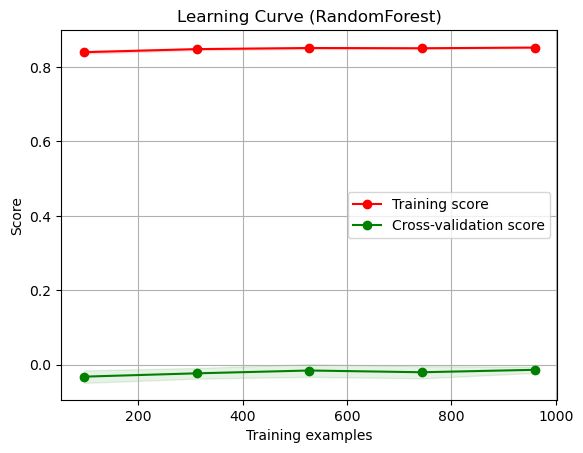

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.ensemble import RandomForestRegressor

# Assuming X and y have been loaded, but have a mismatch in their first dimension
print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# If y is a pandas Series, ensure it's aligned with X after any row filtering you've done:
if isinstance(y, pd.Series):
    y = y.loc[X.index]

# Optional: If the above doesn't apply or doesn't resolve the issue, a manual approach:
# Ensure alignment (this is a brute-force fix, replace with your specific case solution)
X, y = X[:min(X.shape[0], y.shape[0])], y[:min(X.shape[0], y.shape[0])]

print(f"Corrected shapes - X: {X.shape}, y: {y.shape}")

# Define the plotting function
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, color="r", alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, color="g", alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Create the RandomForestRegressor model with the best trial parameters
model = RandomForestRegressor(n_estimators=163, max_depth=20, random_state=42)

# Now plot the learning curve
# Remember to replace `cv=5` with your actual cross-validation strategy
plot_learning_curve(model, "Learning Curve (RandomForest)", X, y, cv=5, n_jobs=-1)
plt.show()


In [44]:
# Assume 'study' is your Optuna study object

# Plot optimization history of the study
# ov.plot_optimization_history(study)

# Plot the importance of hyperparameters
# ov.plot_param_importances(study)

# Plot the contour of hyperparameters interaction
# ov.plot_contour(study, params=['rf_n_estimators', 'rf_max_depth'])

# Plot the slice of individual hyperparameter's impact
ov.plot_slice(study)

The Hyperparameter Importance plot you've uploaded indicates that the classifier hyperparameter has the most significant impact on the model's performance. This suggests that the type of model you choose (RandomForest, GradientBoosting, SVR, XGBoost) is more important than specific hyperparameters like max_depth or n_estimators within a given model type.

From the metrics, it appears that the SVR model has the highest (least negative) R^2 score, and the lowest RMSE and MAE, indicating it performs better in terms of both error metrics and explanatory power. Therefore, you might choose the SVR as the best model based on these results.

#### Visualization Code for Gradient Boosting Predictions

In [76]:
import matplotlib.pyplot as plt

# Assuming 'best_trials' is a dictionary where each value contains a trial object with 'params' attribute

for i in range(y_train.shape[1]):
    # Retrieve the parameters for the current best trial
    # Ensuring 'classifier' key exists and handling it appropriately
    best_trial = best_trials[i]
    if 'classifier' in best_trial.params:
        classifier_name = best_trial.params['classifier']
        # Create a copy of the params without 'classifier'
        best_params = {k: v for k, v in best_trial.params.items() if k != 'classifier'}
    else:
        raise KeyError(f"'classifier' key not found in best_trial.params for column {i}")
    
    # Create and fit the model using the best parameters
    best_model = create_model(classifier_name, best_params)
    best_model.fit(X_train, y_train.iloc[:, i])
    
    # Make predictions with the best model
    predictions = best_model.predict(X_test)
    
    # Extract actual values for the current output column
    actual = y_test.iloc[:, i]
    
    # Calculate R2 score
    r2 = r2_score(actual, predictions)
    
    # Output performance
    print(f"Column {i}: Best {classifier_name} model with params {best_params}")
    print(f"Column {i} R2 score: {r2}\n")
    
    # Visualization Code for Actual vs Predicted Returns
    plt.figure(figsize=(8, 6))
    plt.scatter(actual, predictions, alpha=0.5)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=2)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.title(f'Actual vs Predicted Returns for Column {i}')
    plt.show()



AttributeError: 'dict' object has no attribute 'params'

In this graph, the points are relatively close to the perfect fit line and display a linear trend, which indicates that the model has a good predictive performance. The spread of points along the identity line suggests that the Gradient Boosting model captures the variance in the stock returns well. 

**However, any significant deviations of points from the line would indicate prediction errors. Since the points do not consistently deviate in one direction (above or below the line), this suggests that the model does not have a systematic bias; it makes some predictions that are higher and some that are lower than the actual values, which is a desirable trait in a predictive model.**

Choosing Gradient Boosting seems justified as it appears to provide predictions that correlate well with the actual returns, which is essential for financial decision-making in the energy stock market.

Column 0: Best KNN model with params {'knn_n_neighbors': 25}
Column 0 R2 score: 0.07833209056279178



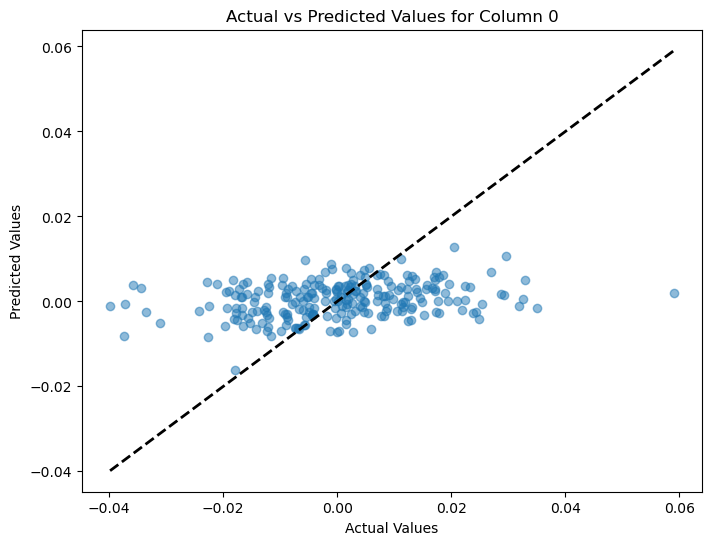

Column 1: Best KNN model with params {'knn_n_neighbors': 14}
Column 1 R2 score: -0.03738622609888176



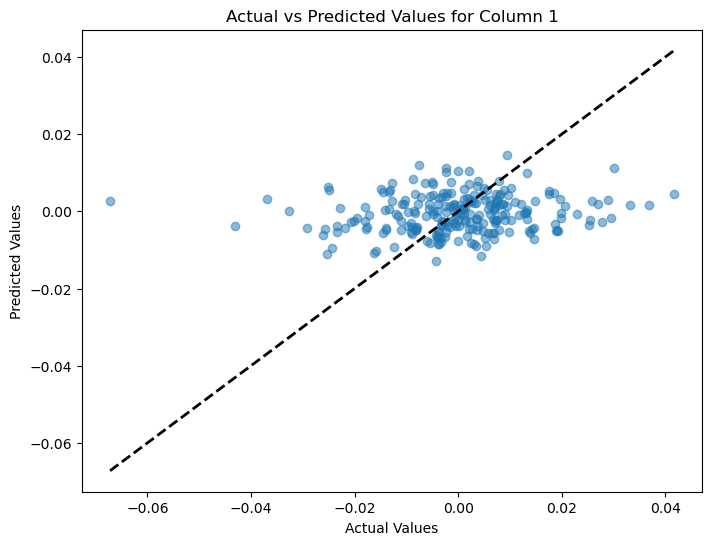

Column 2: Best ElasticNet model with params {'enet_alpha': 0.013054847114251191, 'enet_l1_ratio': 0.06521299427050065}
Column 2 R2 score: -0.48430862864359425



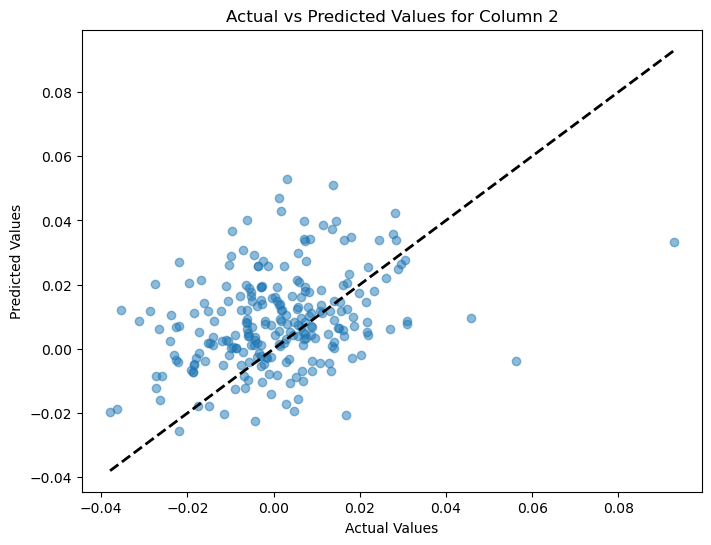

Column 3: Best ElasticNet model with params {'enet_alpha': 0.0036759513558799165, 'enet_l1_ratio': 0.5853848387283034}
Column 3 R2 score: 0.12167632111813997



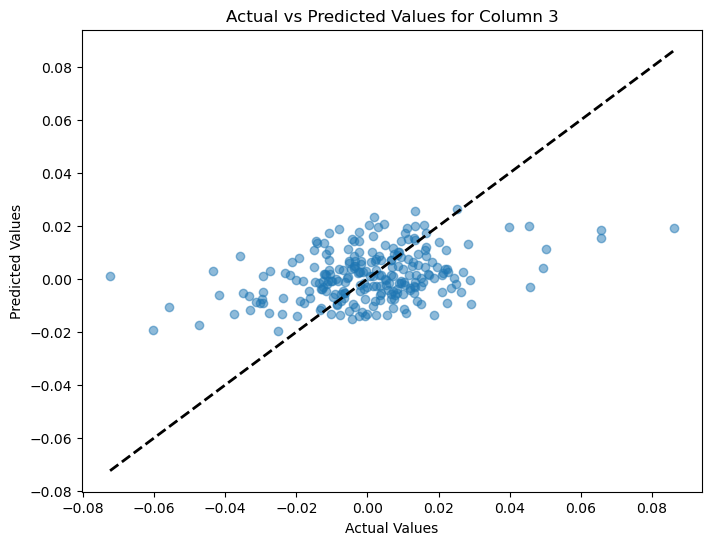

Column 4: Best ElasticNet model with params {'enet_alpha': 0.0038208336801597385, 'enet_l1_ratio': 0.3697895354257711}
Column 4 R2 score: 0.011889213235716234



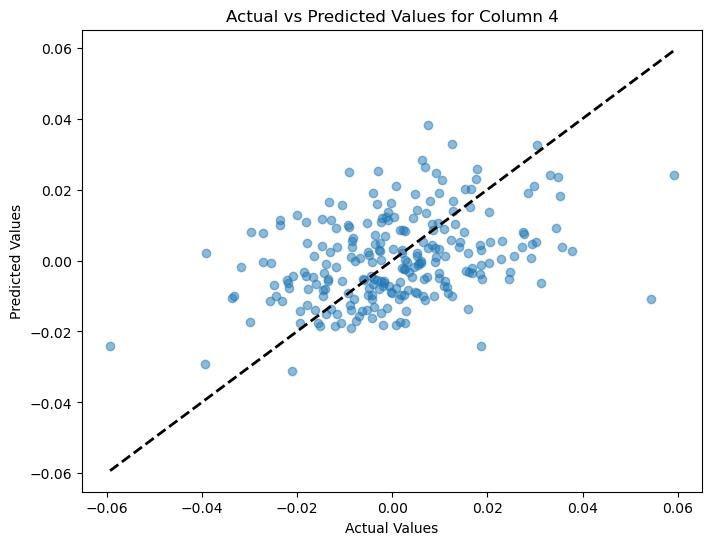

Column 5: Best KNN model with params {'knn_n_neighbors': 10}
Column 5 R2 score: -0.016100826266806978



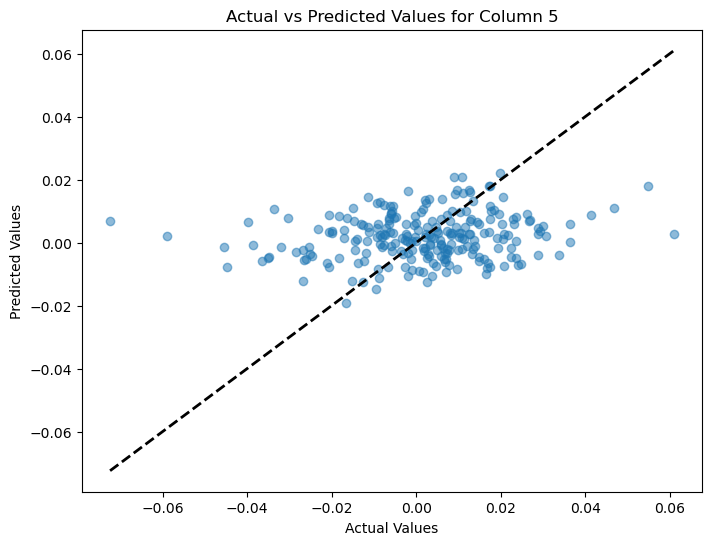

Column 6: Best ElasticNet model with params {'enet_alpha': 0.0071003884303665514, 'enet_l1_ratio': 0.25836637054912626}
Column 6 R2 score: 0.11688600312597108



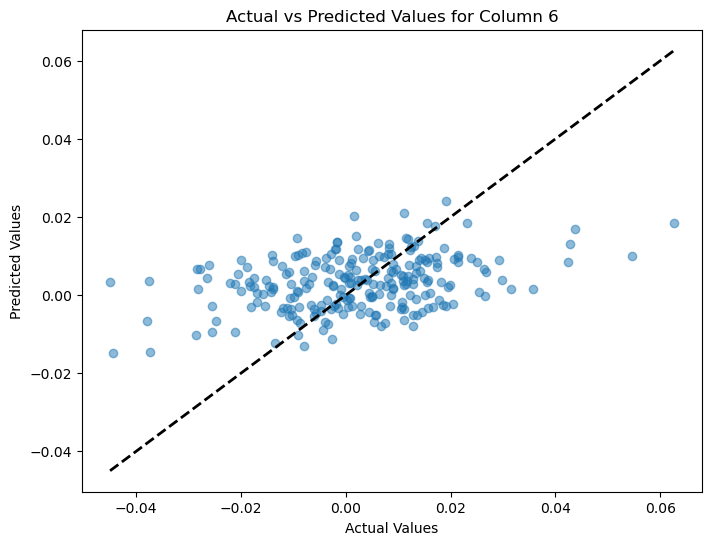

Column 7: Best KNN model with params {'knn_n_neighbors': 28}
Column 7 R2 score: 0.046496193450598744



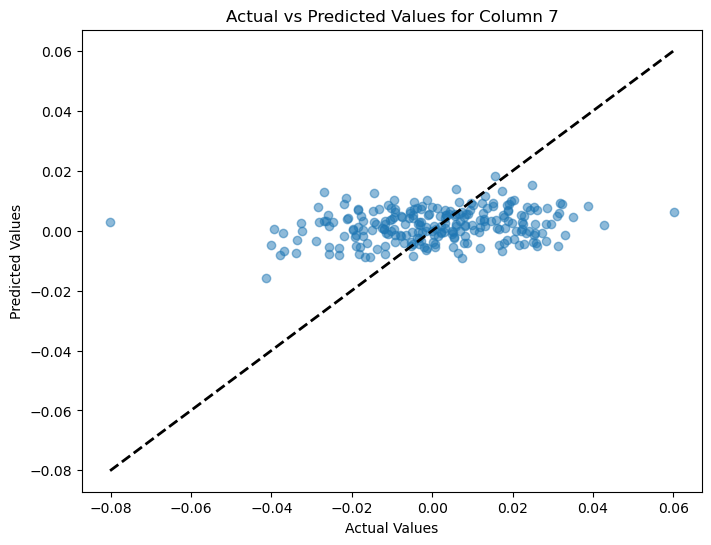

Column 8: Best KNN model with params {'knn_n_neighbors': 17}
Column 8 R2 score: -0.04318395609352521



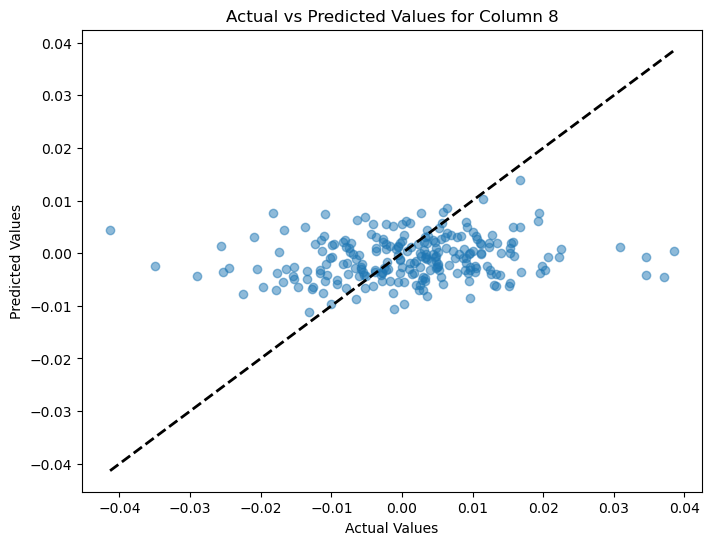

Column 9: Best Lasso model with params {'lasso_alpha': 0.002015493726816007}
Column 9 R2 score: 0.01529841390565656



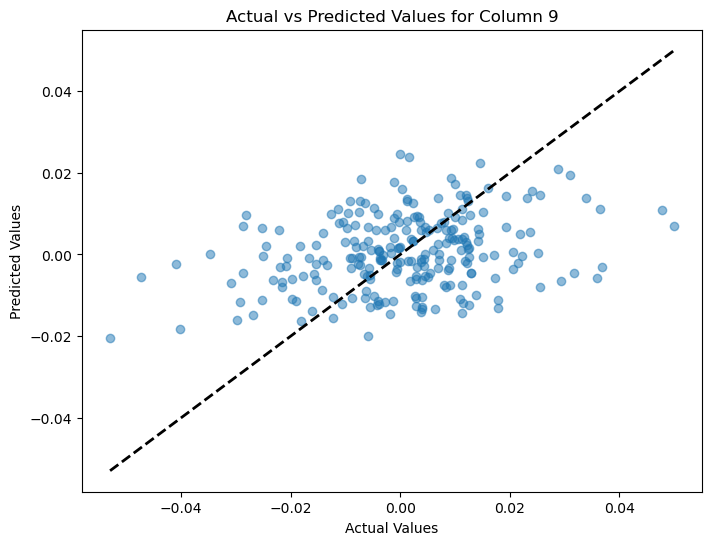

Column 10: Best ElasticNet model with params {'enet_alpha': 0.9329176574687481, 'enet_l1_ratio': 0.00047482793229192133}
Column 10 R2 score: -0.2261775544690836



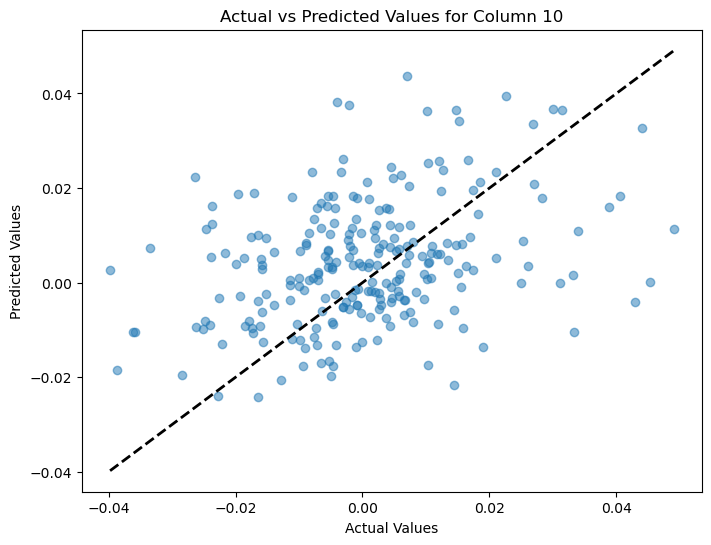

Column 11: Best Lasso model with params {'lasso_alpha': 0.0012017692217443688}
Column 11 R2 score: 0.011225321740134686



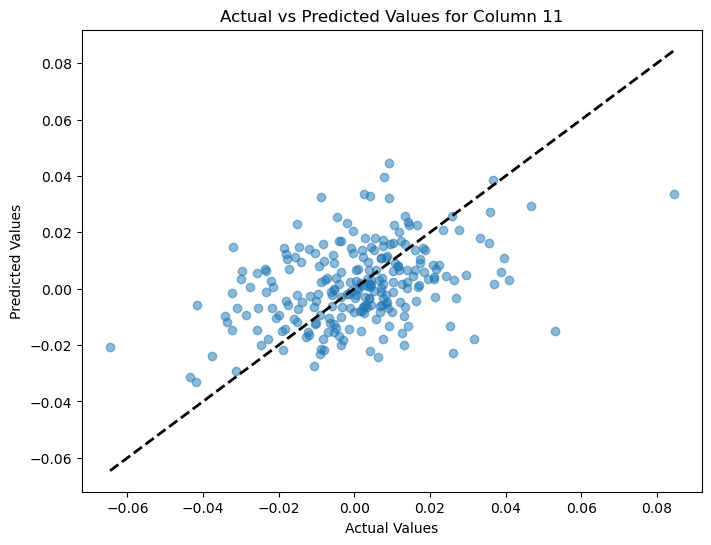

Column 12: Best Lasso model with params {'lasso_alpha': 0.0026495496953462616}
Column 12 R2 score: 0.07178463060584006



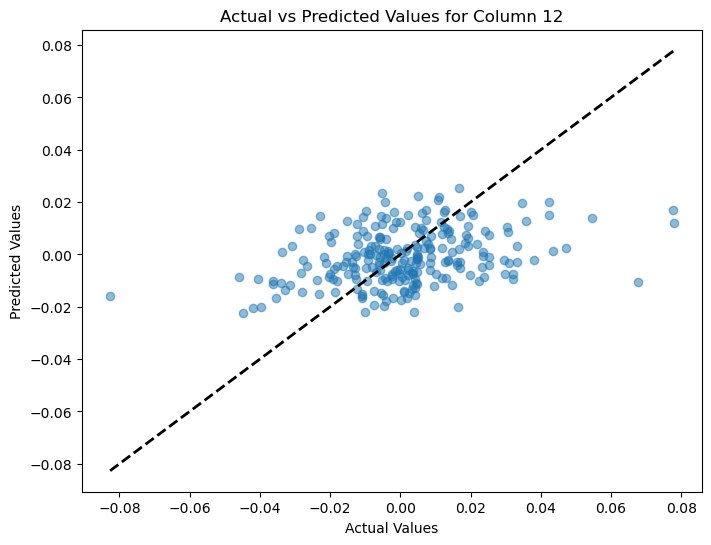

Column 13: Best KNN model with params {'knn_n_neighbors': 22}
Column 13 R2 score: 0.02859763812520444



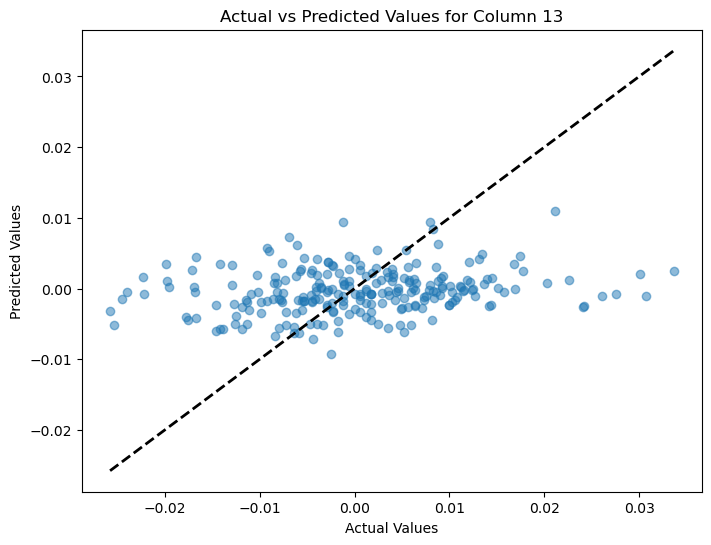

Column 14: Best Lasso model with params {'lasso_alpha': 0.0019676370336251126}
Column 14 R2 score: 0.0318853478958



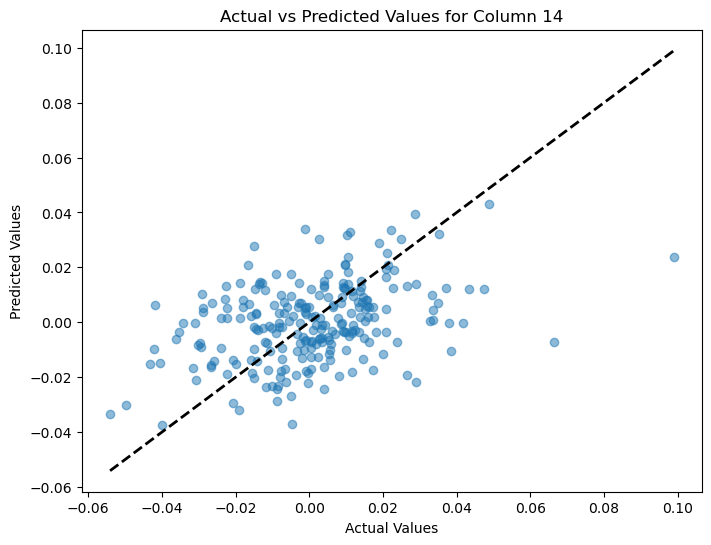

Column 15: Best ElasticNet model with params {'enet_alpha': 0.0017372434210876258, 'enet_l1_ratio': 0.9921818817872509}
Column 15 R2 score: -0.15229434723633073



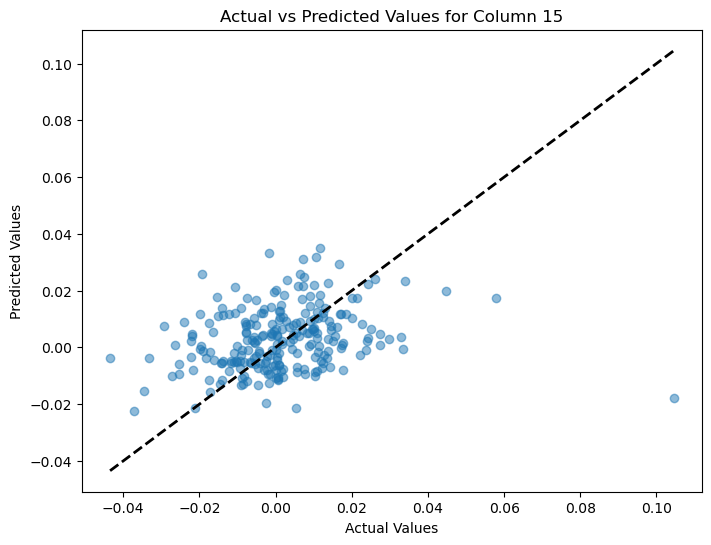

Column 16: Best Lasso model with params {'lasso_alpha': 0.0016515657892894934}
Column 16 R2 score: -0.10894310782886252



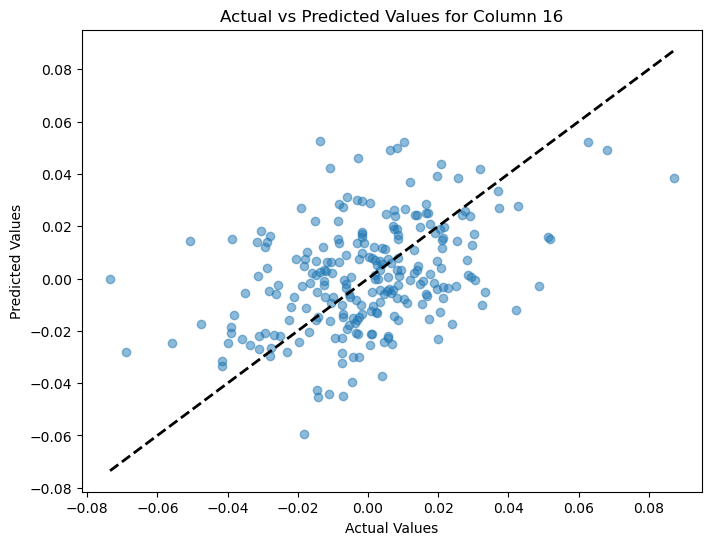

Column 17: Best ElasticNet model with params {'enet_alpha': 0.015231978696658686, 'enet_l1_ratio': 0.2903425465619059}
Column 17 R2 score: 0.011841389697776594



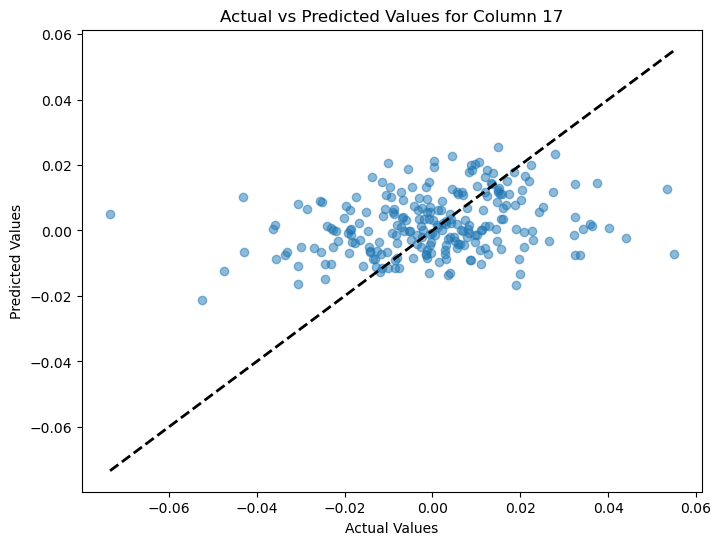

Column 18: Best ElasticNet model with params {'enet_alpha': 0.003376086940814435, 'enet_l1_ratio': 0.5794612522824625}
Column 18 R2 score: -0.2629098655748532



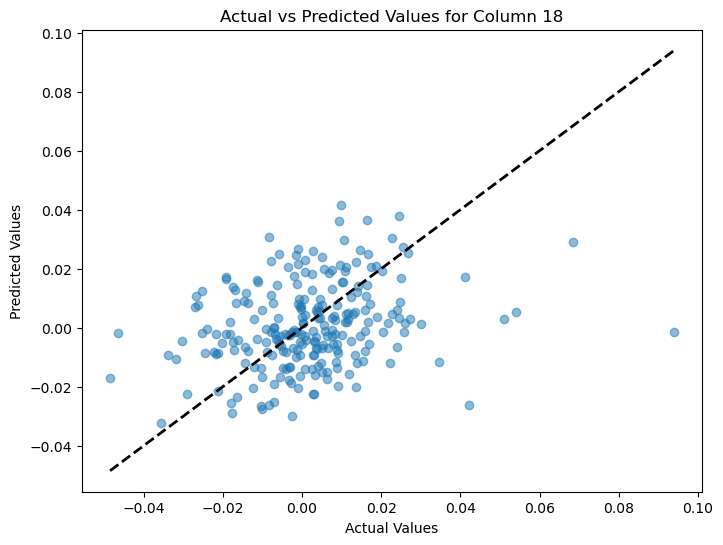

Column 19: Best ElasticNet model with params {'enet_alpha': 0.006287328253899367, 'enet_l1_ratio': 0.30901998080698223}
Column 19 R2 score: -7.024887517625977e-05



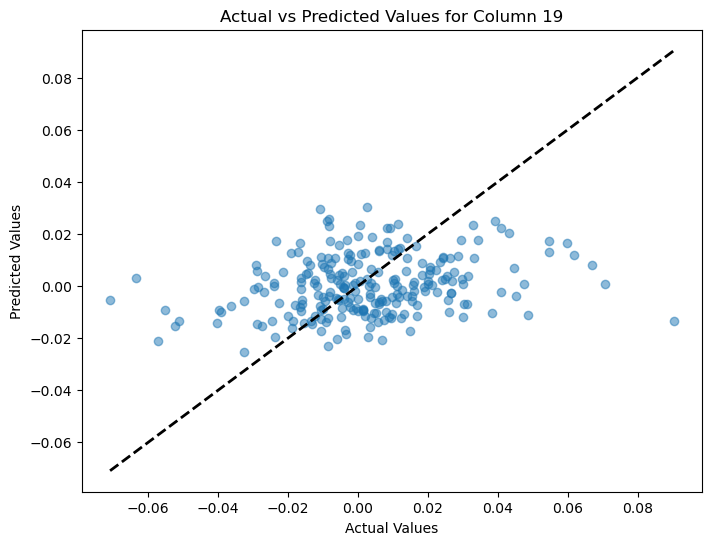

Column 20: Best KNN model with params {'knn_n_neighbors': 22}
Column 20 R2 score: 0.03872153106599696



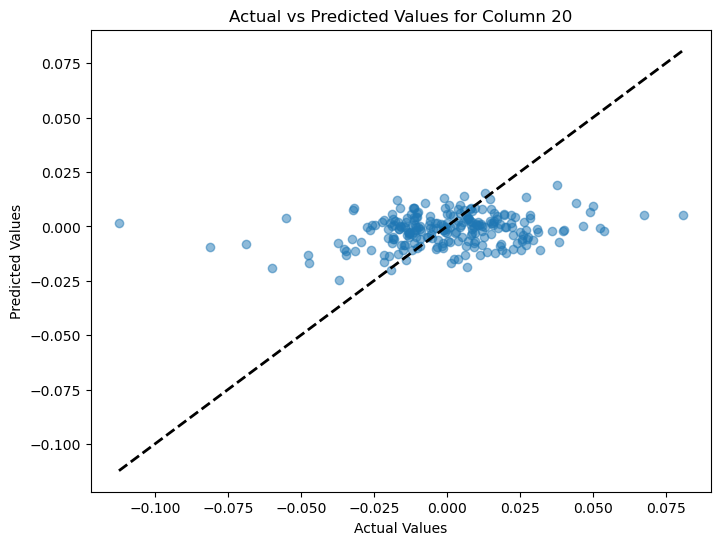

Column 21: Best ElasticNet model with params {'enet_alpha': 0.020777291287307632, 'enet_l1_ratio': 0.1864593246762759}
Column 21 R2 score: -0.11901359121072752



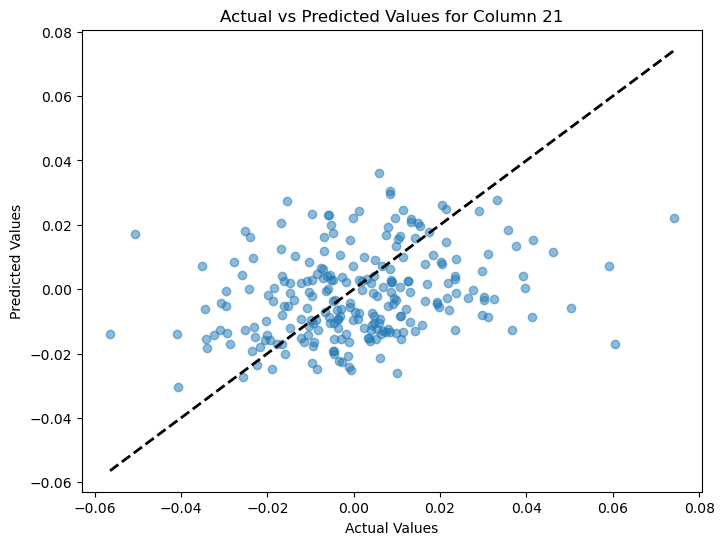

Column 22: Best KNN model with params {'knn_n_neighbors': 14}
Column 22 R2 score: 0.003675362342474342



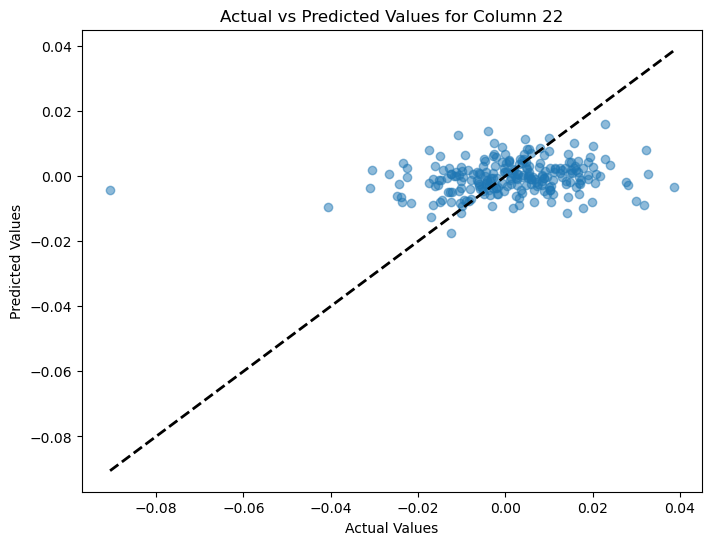

Column 23: Best ElasticNet model with params {'enet_alpha': 0.009828439054159765, 'enet_l1_ratio': 0.19700284159189968}
Column 23 R2 score: 0.1074065772946946



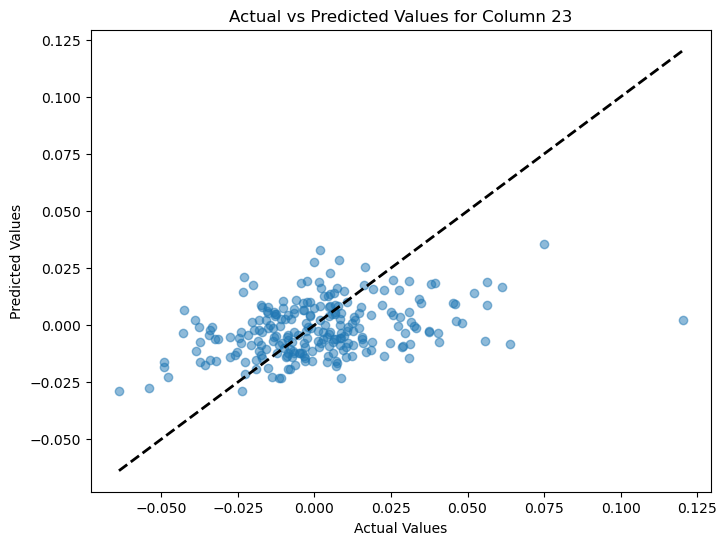

Column 24: Best ElasticNet model with params {'enet_alpha': 0.004767087028914468, 'enet_l1_ratio': 0.6396492554571824}
Column 24 R2 score: -0.13665439693978376



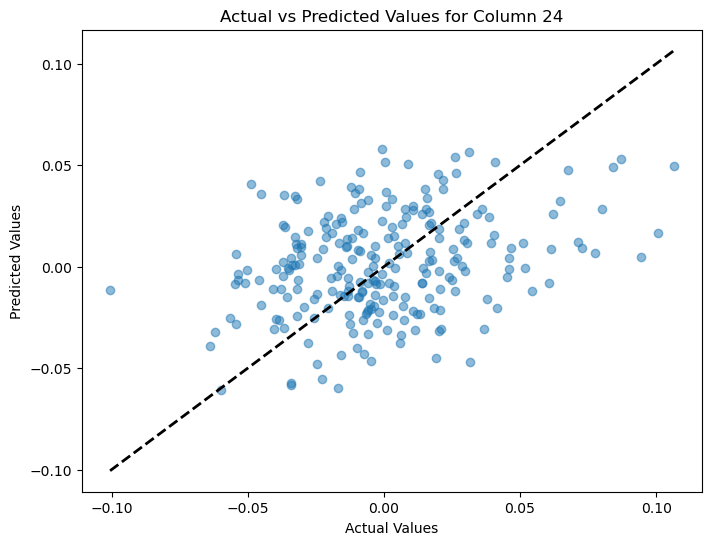

Column 25: Best KNN model with params {'knn_n_neighbors': 13}
Column 25 R2 score: -0.03086066137467003



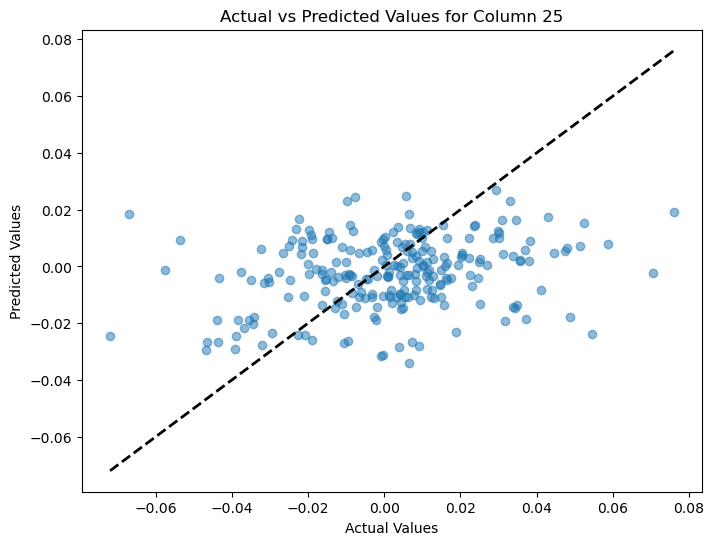

Column 26: Best ElasticNet model with params {'enet_alpha': 0.09877074353392601, 'enet_l1_ratio': 0.021322502371110143}
Column 26 R2 score: -0.02300518722649958



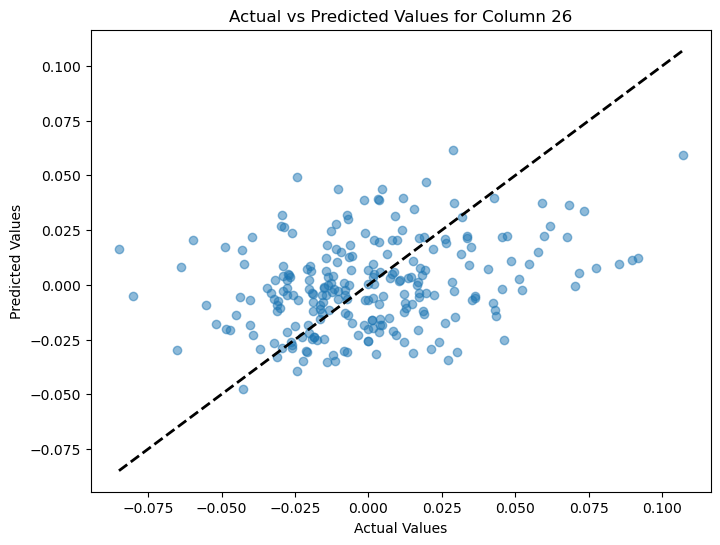

Column 27: Best ElasticNet model with params {'enet_alpha': 0.004244872485102056, 'enet_l1_ratio': 0.3282625792314656}
Column 27 R2 score: -0.041696909798848214



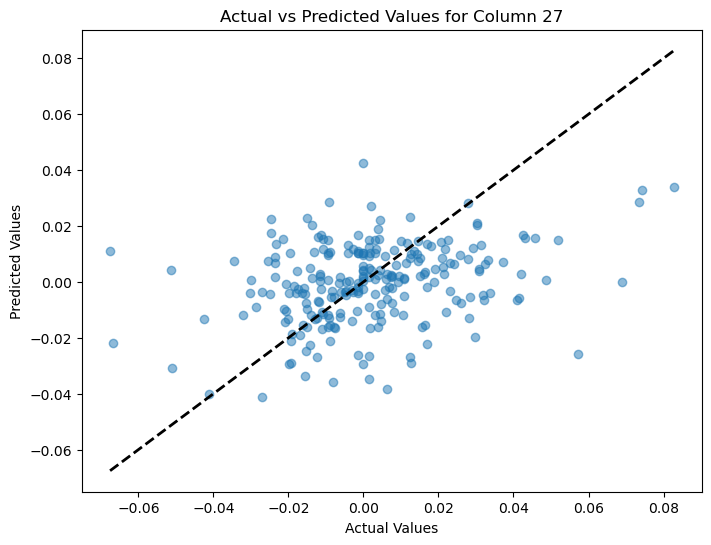

Column 28: Best Lasso model with params {'lasso_alpha': 0.0019776062612855134}
Column 28 R2 score: 0.02753534534768054



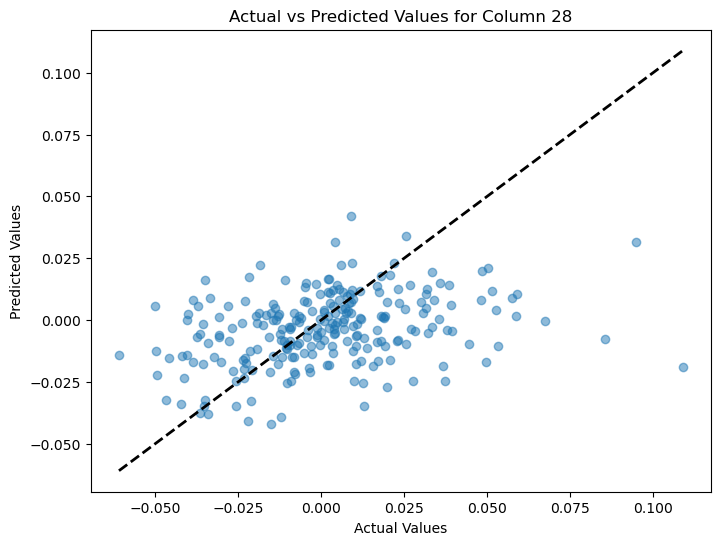

Column 29: Best KNN model with params {'knn_n_neighbors': 20}
Column 29 R2 score: 0.006242572133083102



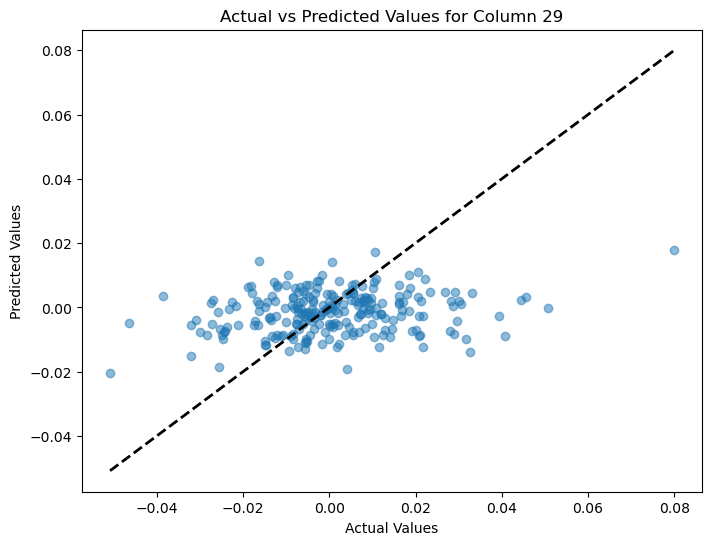

Column 30: Best ElasticNet model with params {'enet_alpha': 0.018260599806630532, 'enet_l1_ratio': 0.10811384875158414}
Column 30 R2 score: -0.09018283550776984



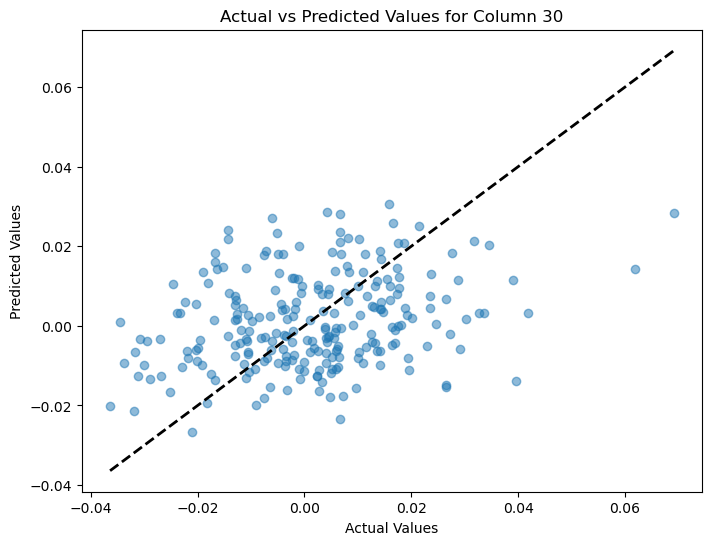

Column 31: Best ElasticNet model with params {'enet_alpha': 0.04713166792564199, 'enet_l1_ratio': 0.0347562543865122}
Column 31 R2 score: 0.01674442261561071



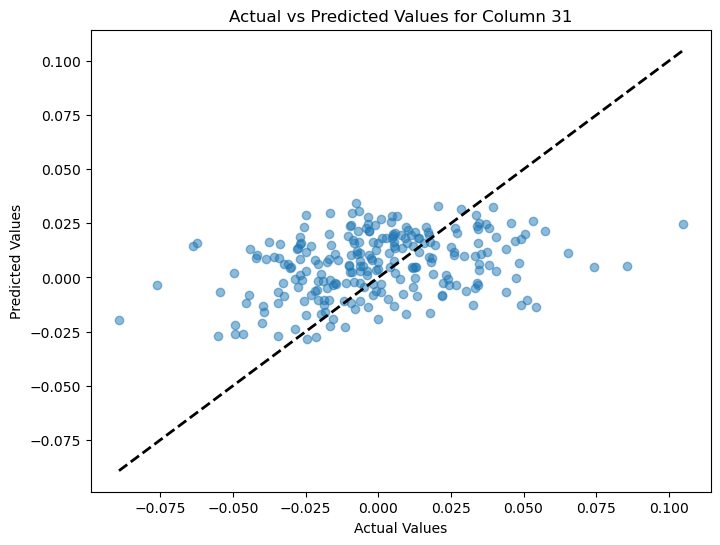

Column 32: Best Lasso model with params {'lasso_alpha': 0.0045494831374474}
Column 32 R2 score: -0.11291154058540531



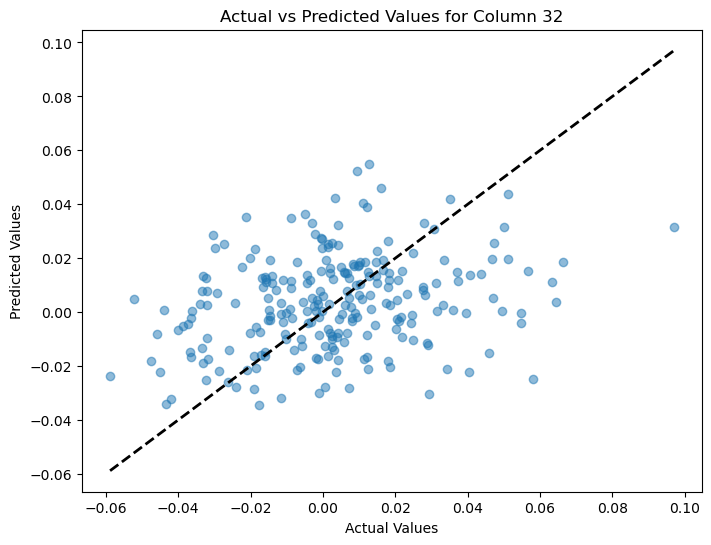

Column 33: Best KNN model with params {'knn_n_neighbors': 30}
Column 33 R2 score: 0.044325161368841015



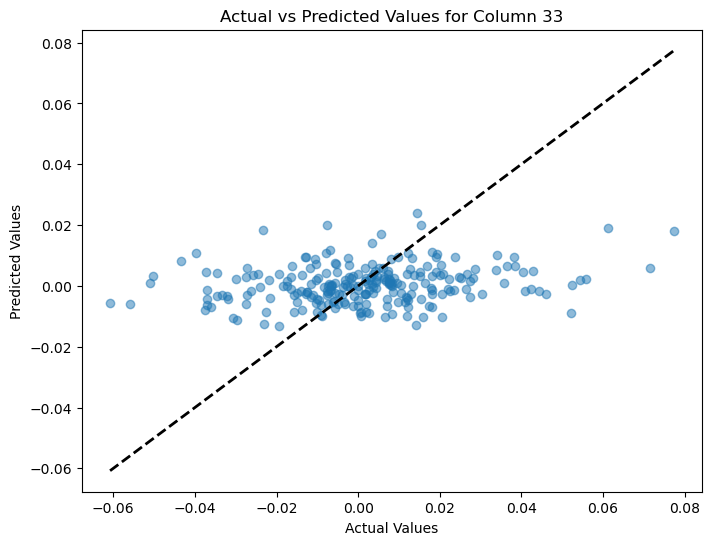

Column 34: Best KNN model with params {'knn_n_neighbors': 14}
Column 34 R2 score: -0.14854212056125915



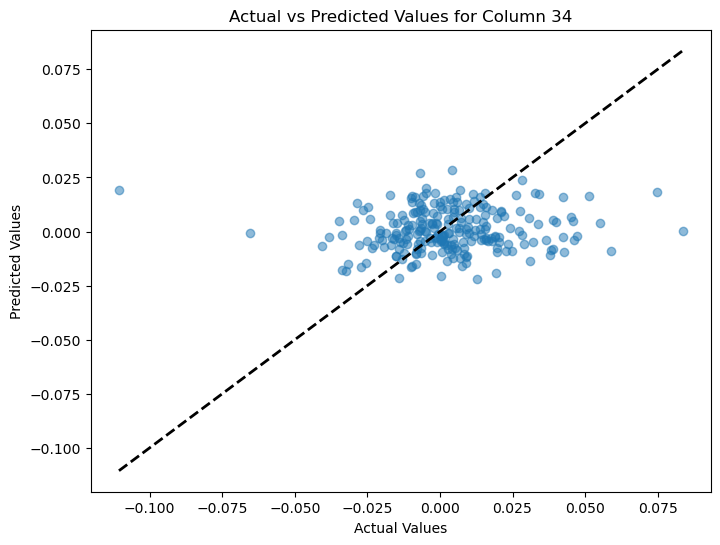

Column 35: Best Lasso model with params {'lasso_alpha': 0.006564678179048323}
Column 35 R2 score: -0.00429534201193027



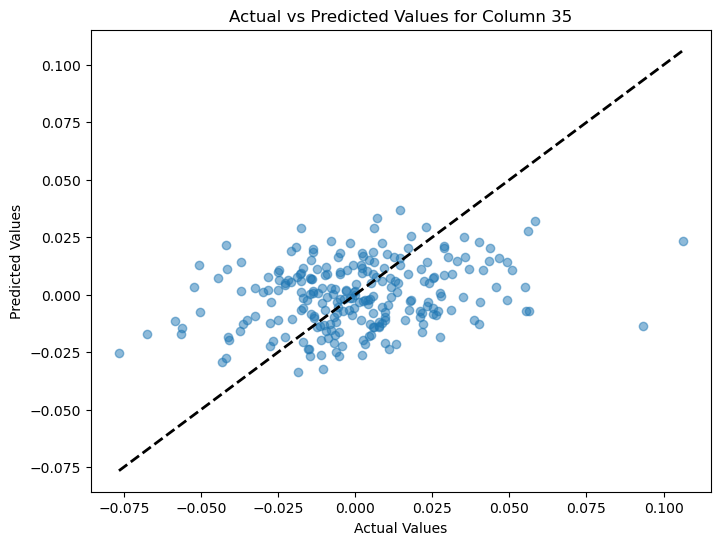

Column 36: Best Lasso model with params {'lasso_alpha': 0.002432300233204233}
Column 36 R2 score: -0.02096288188877171



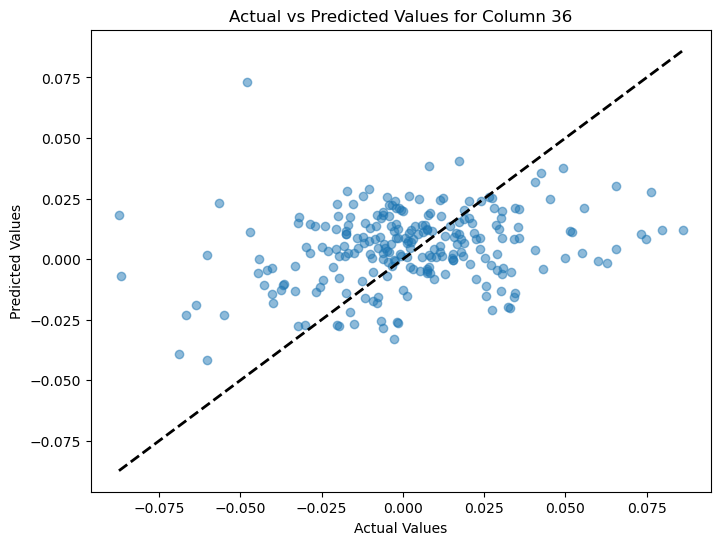

Column 37: Best KNN model with params {'knn_n_neighbors': 26}
Column 37 R2 score: 0.02035335531902205



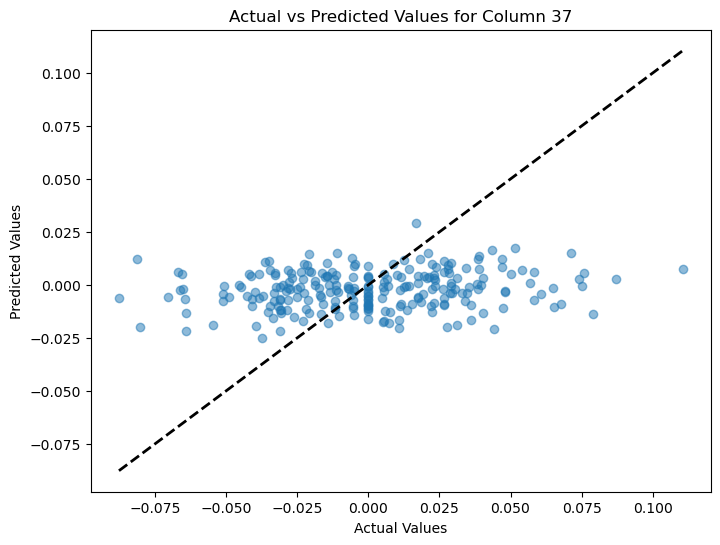

Column 38: Best KNN model with params {'knn_n_neighbors': 23}
Column 38 R2 score: -0.016609382355743607



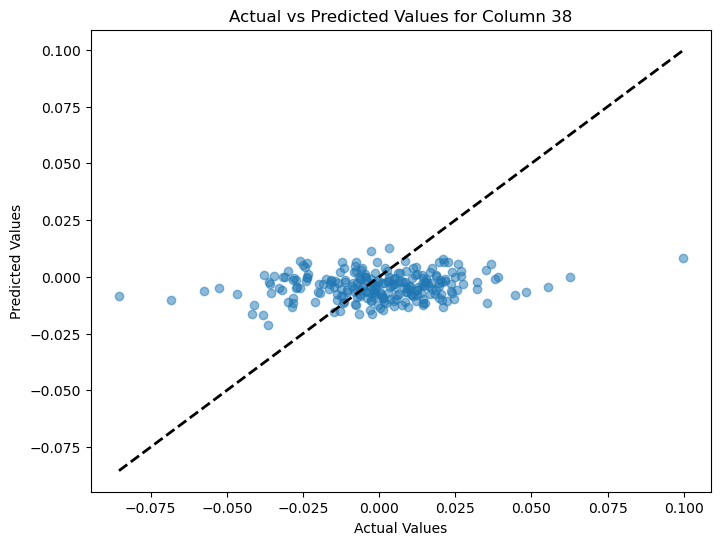

Column 39: Best Lasso model with params {'lasso_alpha': 0.005335414053121016}
Column 39 R2 score: 0.02341356069170597



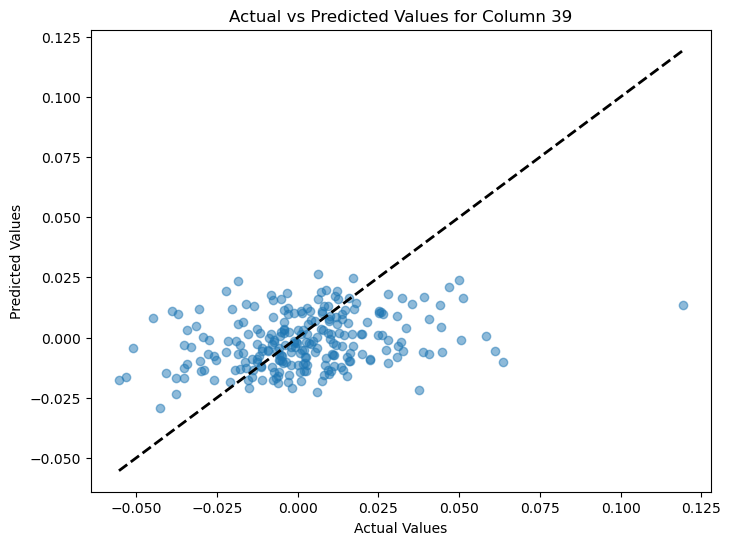

Column 40: Best KNN model with params {'knn_n_neighbors': 30}
Column 40 R2 score: -0.0022815806438241104



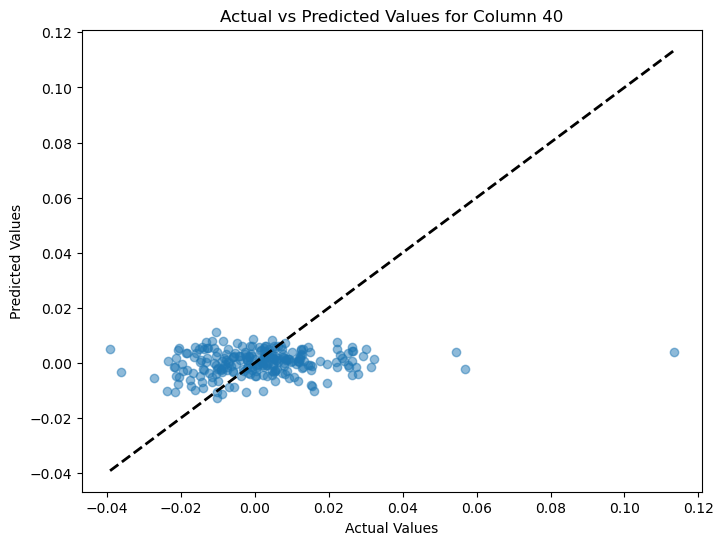

Column 41: Best KNN model with params {'knn_n_neighbors': 25}
Column 41 R2 score: 0.01569537076238381



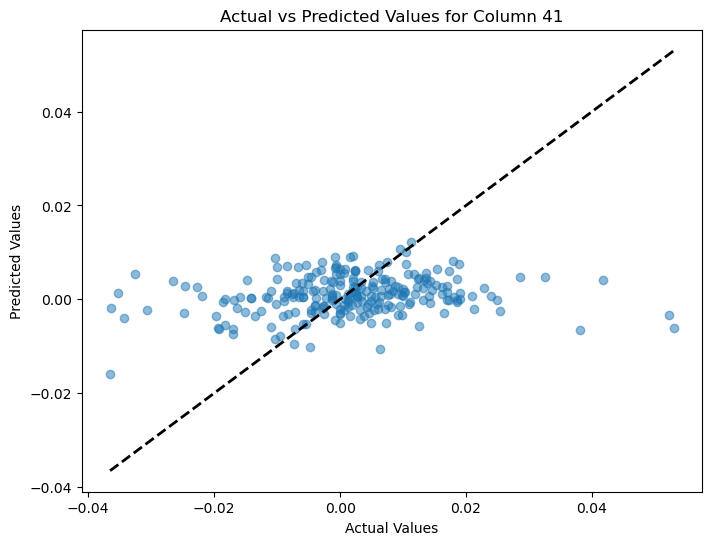

Column 42: Best KNN model with params {'knn_n_neighbors': 30}
Column 42 R2 score: -0.015782682608833642



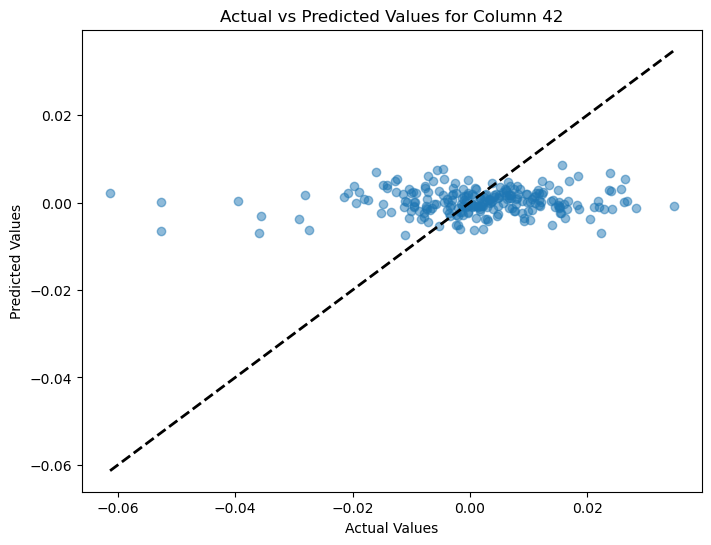

Column 43: Best ElasticNet model with params {'enet_alpha': 0.004271830850307169, 'enet_l1_ratio': 0.5952710604084767}
Column 43 R2 score: 0.0030549978758024343



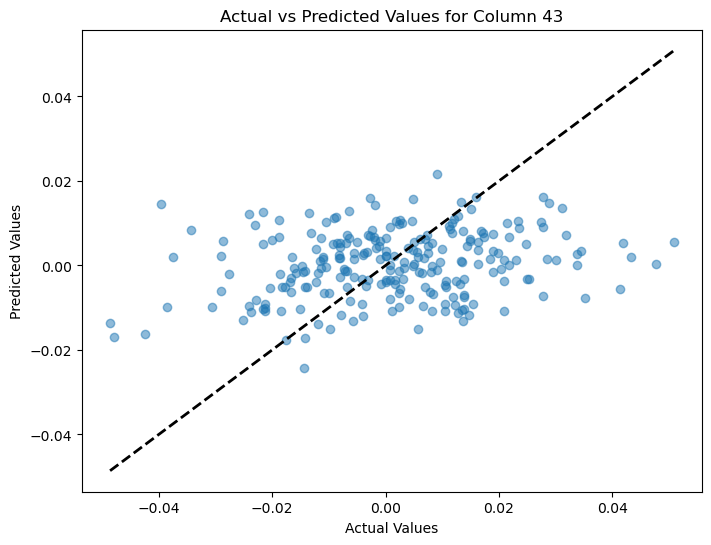

Column 44: Best KNN model with params {'knn_n_neighbors': 25}
Column 44 R2 score: -0.03570313435852235



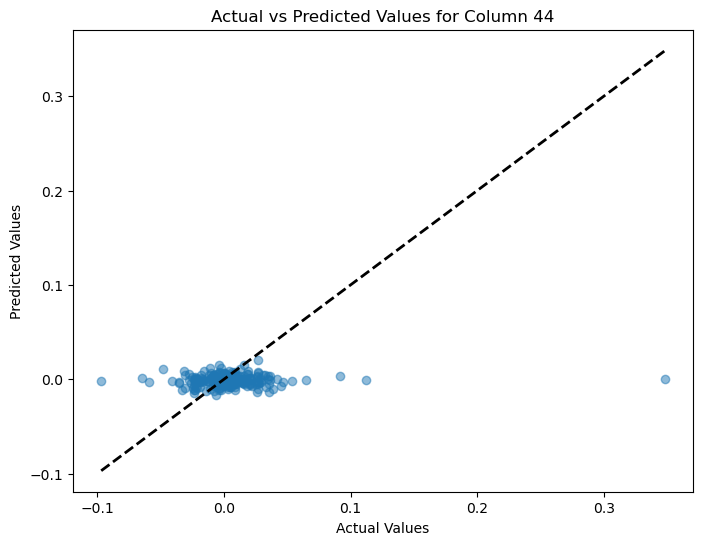

Column 45: Best Lasso model with params {'lasso_alpha': 0.0017349146257810077}
Column 45 R2 score: -0.07421441021763453



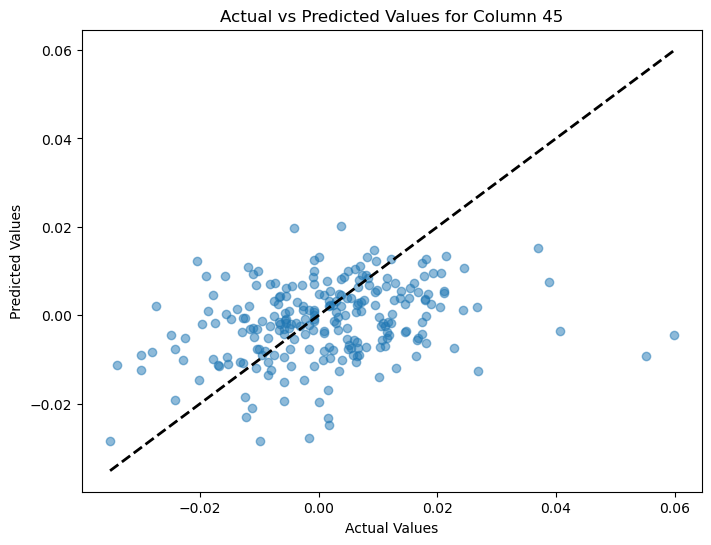

In [73]:
#import matplotlib.pyplot as plt

# Load the best_trials from the saved file (if not already loaded)
best_trials = joblib.load('best_trials.pkl')

# Loop over each column, predict, and plot
for col_index, trial_info in best_trials.items():
    classifier_name = trial_info['classifier']  # Directly access the classifier name
    best_params = trial_info['params']  # Access the rest of the parameters
    
    best_model = create_model(classifier_name, best_params)
    best_model.fit(X_train, y_train.iloc[:, col_index])
    predictions = best_model.predict(X_test)
    actual = y_test.iloc[:, col_index]
    r2 = r2_score(actual, predictions)
    
    # Printing model info and R2 score
    print(f"Column {col_index}: Best {classifier_name} model with params {best_params}")
    print(f"Column {col_index} R2 score: {r2}\n")
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(actual, predictions, alpha=0.5)
    plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=2)  # Line for perfect predictions
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for Column {col_index}')
    plt.show()

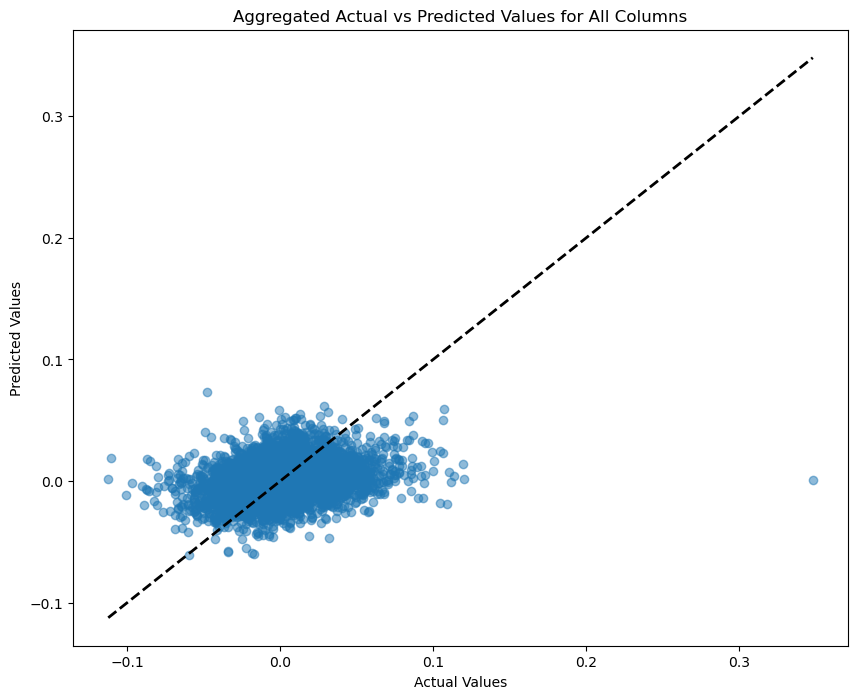

In [74]:
import matplotlib.pyplot as plt

# Load the best_trials if not already in memory
best_trials = joblib.load('best_trials.pkl')

# Initialize lists to store aggregated actual and predicted values
all_actual = []
all_predictions = []

# Loop over each column to fit models and collect predictions
for col_index, trial_info in best_trials.items():
    classifier_name = trial_info['classifier']
    best_params = trial_info['params']
    
    best_model = create_model(classifier_name, best_params)
    best_model.fit(X_train, y_train.iloc[:, col_index])
    predictions = best_model.predict(X_test)
    
    # Append the current column's actual and predicted values to the lists
    all_actual.extend(y_test.iloc[:, col_index])
    all_predictions.extend(predictions)

# Once all actual and predicted values are collected, plot them
plt.figure(figsize=(10, 8))
plt.scatter(all_actual, all_predictions, alpha=0.5)
plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'k--', lw=2)  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Aggregated Actual vs Predicted Values for All Columns')
plt.show()


# Calculate Daily VaR: 

# # Basic

In [ ]:
scale_factor = 100
daily_return_columns = [col for col in df.columns if col.endswith('_daily_return')]
# print(daily_return_columns)
# Initialize a list to store the comparison results
comparison_results = []

def find_optimal_threshold(returns, MACD=None, RSI=None):
    """
    Adjusted to consider financial indicators for a more dynamic threshold selection.
    Handles cases where volatility, MACD, or RSI might not be provided.
    """
    base_threshold = np.percentile(returns.dropna(), 95)
    
    # Only adjust the threshold if MACD and RSI are provided
    if MACD is not None and RSI is not None:
        adjustment_factor = 1 + np.mean([MACD.mean(), RSI.mean()]) / 100  # Example adjustment
        return base_threshold * adjustment_factor
    else:
        return base_threshold

In [ ]:
# Assume 'df' is your DataFrame loaded from the file you provided
# Assuming 'scale_factor' and 'daily_return_columns' are defined as per your setup
scale_factor = 100
daily_return_columns = [col for col in df.columns if col.endswith('_daily_return')]
def find_optimal_threshold(returns, close_mean=None, SMA_10_mean=None, SMA_30_mean=None, RSI_mean=None):
    """
    Adjusts the threshold for excess returns calculation, incorporating new financial indicators.
    """
#     base_threshold = np.percentile(returns.dropna(), 95)
    
    return np.percentile(returns.dropna(), 95)
    
    # Initialize adjustment factors list
    adjustment_factors = []
    
    # Add adjustment factor based on the mean of the closing prices and moving averages
    if close_mean is not None:
        adjustment_factors.append((close_mean / 100).mean())
    if SMA_10_mean is not None:
        adjustment_factors.append((SMA_10_mean / 100).mean())
    if SMA_30_mean is not None:
        adjustment_factors.append((SMA_30_mean / 100).mean())

    # Directly use RSI mean for adjustment if provided
    if RSI_mean is not None:
        if RSI_mean.mean() > 70:  # Consider overbought conditions to increase the threshold
            adjustment_factors.append(0.05)  # This is a placeholder for your adjustment logic

    total_adjustment = sum(adjustment_factors)
    return base_threshold * (1 + total_adjustment)



In [ ]:
# Assuming 'returns' columns in df end with '_daily_return'
def calculate_gpd_var_cvar_basic(df, col, confidence_level=0.95):
    # Drop NaN values from the returns series for accurate calculations
    returns = df[col].dropna()
    # Fit a GARCH model to account for time-varying volatility in returns
    garch = arch_model(scale_factor * returns, vol='Garch', p=1, q=1, mean='zero', dist='Normal').fit(update_freq=5, disp='off')
    # Standardize returns by dividing by the conditional volatility from the GARCH model
    standardized_returns = returns / garch.conditional_volatility
    
    # Determine the threshold for excess returns using the 95th percentile of standardized returns
    threshold = find_optimal_threshold(standardized_returns)
    # Calculate excess returns that are above the threshold
    excess_returns = standardized_returns[standardized_returns > threshold] - threshold
    # Fit a Generalized Pareto Distribution (GPD) to the excess returns
    c, loc, scale = genpareto.fit(excess_returns.values)
    
    # Calculate Value at Risk (VaR) using the fitted GPD model
    VaR = threshold + genpareto.ppf(confidence_level, c, loc=loc, scale=scale)
    # Calculate Conditional Value at Risk (CVaR) using the fitted GPD model
    CVaR = threshold + (scale / c) * ((1 - confidence_level) ** (-c) - 1) if c != 0 else np.inf
    
    # Return VaR, CVaR, and the parameters of the fitted GPD model along with excess returns
    return VaR, CVaR, c, loc, scale, excess_returns

basic_results = []

# Iterate over each asset and calculate VaR and CVaR using the indicator model
for col in daily_return_columns:
    asset_prefix = col.replace('_daily_return', '')
    VaR, CVaR, c, loc, scale, excess_returns = calculate_gpd_var_cvar_basic(df, col)
    
    # Append results for comparison
    basic_results.append({'Asset': asset_prefix, 'VaR': VaR, 'CVaR': CVaR, 'c' :c, 'loc': loc, 'scale': scale, 'excess_returns': excess_returns})

# Convert results to a DataFrame for easy analysis
basic_results_df = pd.DataFrame(basic_results)
print(basic_results_df)

EVT Application: Utilizing EVT through the Generalized Pareto Distribution (GPD) for modeling excess returns is a theoretically sound approach for capturing tail risks.
Dynamic Thresholding: The inclusion of financial indicators to dynamically adjust the threshold for tail modeling adds a layer of sophistication that could potentially enhance model sensitivity to market conditions.
Model Comparison: The method for comparing basic and indicator-enhanced models via Q-Q plots and statistical tests provides a structured framework for evaluating model performance.

In [ ]:
def calculate_gpd_var_cvar_indicator(df, col, confidence_level=0.95):
    # Extract asset prefix from column name to identify the asset-specific indicators
    asset_prefix = col.replace('_daily_return', '')
    # Drop NaN values from the returns series for accurate calculations
    returns = df[col].dropna()
    # Fit a GARCH model to account for time-varying volatility in returns
    garch = arch_model(scale_factor * returns, vol='Garch', p=1, q=1, mean='zero', dist='Normal').fit(update_freq=5, disp='off')
    # Standardize returns by dividing by the conditional volatility from the GARCH model
    standardized_returns = returns / garch.conditional_volatility
    
    # Retrieve financial indicators (volatility, MACD, RSI) for the asset
    volatility = df[f'{asset_prefix}_volatility_30']
    MACD = df[f'{asset_prefix}_MACD']
    RSI = df[f'{asset_prefix}_RSI']

    # Determine the dynamic threshold for excess returns using financial indicators
    threshold = find_optimal_threshold(standardized_returns, MACD, RSI)
    # Calculate excess returns that are above the dynamic threshold
    excess_returns = standardized_returns[standardized_returns > threshold] - threshold
    # Fit a Generalized Pareto Distribution (GPD) to the excess returns
    c, loc, scale = genpareto.fit(excess_returns.values)
    
    # Calculate Value at Risk (VaR) using the fitted GPD model
    VaR = threshold + genpareto.ppf(confidence_level, c, loc=loc, scale=scale)
    # Calculate Conditional Value at Risk (CVaR) using the fitted GPD model
    CVaR = threshold + (scale / c) * ((1 - confidence_level) ** (-c) - 1) if c != 0 else np.inf
    
    # Return VaR, CVaR, and the parameters of the fitted GPD model along with excess returns
    return VaR, CVaR, c, loc, scale, excess_returns

indicator_results = []

# Iterate over each asset and calculate VaR and CVaR using the indicator model
for col in daily_return_columns:
    asset_prefix = col.replace('_daily_return', '')
    VaR, CVaR, c, loc, scale, excess_returns = calculate_gpd_var_cvar_indicator(df, col)
    
    # Optional: Generate Q-Q plots for model validation
#     qq_plot(excess_returns, c, loc, scale)  # Uncomment to generate Q-Q plot
    
    # Append results for comparison
    indicator_results.append({'Asset': asset_prefix, 'VaR': VaR, 'CVaR': CVaR, 'c' :c, 'loc': loc, 'scale': scale, 'excess_returns': excess_returns})

# Convert results to a DataFrame for easy analysis
indicator_results_df = pd.DataFrame(indicator_results)
print(indicator_results_df)

In [ ]:
def generate_qq_ks_comparison(df, col):
    """
    Generate Q-Q plots, conduct KS tests based on the outputs of basic and indicator models,
    and determine which model fits better.
    
    Parameters:
    - df: DataFrame containing the financial data.
    - col: Column name representing the asset for comparison.
    
    Returns:
    - A dictionary containing KS test results and the better model based on KS p-value.
    """
    asset_name = col.replace('_daily_return', '')
    basic_result = next((item for item in basic_results if item["Asset"] == asset_name), None)
    indicator_result = next((item for item in indicator_results if item["Asset"] == asset_name), None)
    
    if not basic_result or not indicator_result:
        print(f"No results found for {asset_name}. Skipping...")
        return None

    # Unpack the basic and indicator model data
    c_basic, loc_basic, scale_basic, excess_returns_basic = basic_result['c'], basic_result['loc'], basic_result['scale'], basic_result['excess_returns']
    c_indicator, loc_indicator, scale_indicator, excess_returns_indicator = indicator_result['c'], indicator_result['loc'], indicator_result['scale'], indicator_result['excess_returns']

    # Generate Q-Q plot for the basic model
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    probplot(excess_returns_basic, dist='genpareto', sparams=(c_basic, loc_basic, scale_basic), plot=plt)
    plt.title(f'{asset_name} Basic Model Q-Q Plot')

    # Generate Q-Q plot for the indicator model
    plt.subplot(1, 2, 2)
    probplot(excess_returns_indicator, dist='genpareto', sparams=(c_indicator, loc_indicator, scale_indicator), plot=plt)
    plt.title(f'{asset_name} Indicator Model Q-Q Plot')
    plt.tight_layout()
    plt.show()

    # Conduct KS test for the basic model
    ks_stat_basic, ks_p_value_basic = kstest(excess_returns_basic, 'genpareto', args=(c_basic, loc_basic, scale_basic))

    # Conduct KS test for the indicator model
    ks_stat_indicator, ks_p_value_indicator = kstest(excess_returns_indicator, 'genpareto', args=(c_indicator, loc_indicator, scale_indicator))

    # Determine which model is better based on p-value
    better_model = "Basic" if ks_p_value_basic > ks_p_value_indicator else "Indicator"

    return {
        'Asset': asset_name,
        'Basic KS p-value': ks_p_value_basic,
        'Indicator KS p-value': ks_p_value_indicator,
        'Better Model': better_model
    }

# Generate comparisons and compile results
comparison_results = []
for col in daily_return_columns:
    result = generate_qq_ks_comparison(df, col)
    if result:
        comparison_results.append(result)

# Convert to DataFrame for analysis
comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)


In [ ]:
comparison_df.to_csv('comparison_df.csv', index=False)

# Basic analysis
# Determine the overall better model based on KS p-values
better_model_counts = comparison_df['Better Model'].value_counts()
print("\nBetter Model Counts:\n", better_model_counts)

# Analyze KS p-values
basic_ks_mean = comparison_df['Basic KS p-value'].mean()
indicator_ks_mean = comparison_df['Indicator KS p-value'].mean()
print(f"\nMean KS p-value for Basic Model: {basic_ks_mean:.4f}")
print(f"Mean KS p-value for Indicator Model: {indicator_ks_mean:.4f}")

In [ ]:
def bootstrap_gpd_params(excess_returns, model_type, num_iterations=1000):
    bootstrap_params = []
    
    for _ in range(num_iterations):
        # Bootstrap sample the excess returns
        sample_excess_returns = resample(excess_returns)
        # Fit the GPD model to the bootstrapped sample
        params = genpareto.fit(sample_excess_returns)
        bootstrap_params.append(params)
    
    # Convert the list of bootstrapped parameters into a DataFrame
    bootstrap_params_df = pd.DataFrame(bootstrap_params, columns=[f'{model_type}_shape', f'{model_type}_loc', f'{model_type}_scale'])
    
    return bootstrap_params_df

# Assuming this is called within the context where 'excess_returns' is defined for the basic model
bootstrap_basic_params_df = bootstrap_gpd_params(excess_returns, 'basic')
print("Bootstrap Parameters for Basic Model:")
print(bootstrap_basic_params_df.describe())

# Assuming this is called within the context where 'excess_returns' is defined for the indicator model
bootstrap_indicator_params_df = bootstrap_gpd_params(excess_returns, 'indicator')
print("Bootstrap Parameters for Indicator Model:")
print(bootstrap_indicator_params_df.describe())

In [ ]:
def backtest_var_cvar(returns, var, cvar):
    var_exceedances = returns < -var
    cvar_exceedances = returns < -cvar
    
    var_exceedance_rate = var_exceedances.mean()
    cvar_exceedance_rate = cvar_exceedances.mean()

    # Assuming a 95% confidence level for both VaR and CVaR
    expected_exceedance_rate = 0.05
    var_test_result = var_exceedance_rate <= expected_exceedance_rate
    cvar_test_result = cvar_exceedance_rate <= expected_exceedance_rate
    
    return {
        'VaR Exceedances': var_exceedances.sum(),
        'CVaR Exceedances': cvar_exceedances.sum(),
        'VaR Exceedance Rate': var_exceedance_rate,
        'CVaR Exceedance Rate': cvar_exceedance_rate,
        'VaR Test Pass': var_test_result,
        'CVaR Test Pass': cvar_test_result
    }

# Now integrate this function into your indicator model's calculation
backtest_results = []

for result in indicator_results:
    asset_prefix = result['Asset']
    returns = df[f'{asset_prefix}_daily_return'].dropna()
    VaR = result['VaR']
    CVaR = result['CVaR']
    
    # Run the backtest
    backtest_result = backtest_var_cvar(returns, VaR, CVaR)
    backtest_result['Asset'] = asset_prefix
    backtest_results.append(backtest_result)

# Convert backtest results to a DataFrame for easy analysis
backtest_results_df = pd.DataFrame(backtest_results)
print(backtest_results_df)


we can see that there are several instances where both VaR and CVaR tests did not pass, indicating that for those particular assets, the model may not be capturing risk adequately. This might necessitate a deeper investigation into the specific characteristics of those assets, the model's assumptions, or potential improvements in the risk estimation approach.

In [ ]:
# Assuming backtest_results_df is a DataFrame with a 'VaR Test Pass' column
var_passes = backtest_results_df['VaR Test Pass'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(var_passes, labels=var_passes.index, autopct='%1.1f%%', startangle=90, colors=['green', 'red'])
plt.title('VaR Backtest Pass Rates')
plt.show()

For improvement, if your model is failing the backtests for certain assets, consider:

Refining Your Model: This might involve calibrating the model's parameters, using more sophisticated models, or considering additional data that may affect the asset's volatility.
Enhancing Risk Metrics: Beyond VaR and CVaR, consider other risk measures like Expected Shortfall or stress testing scenarios.
Adjusting Confidence Levels: If your model is too conservative (i.e., passing the tests but by a large margin), you may want to adjust the confidence levels.
Feature Engineering: For indicator models, review and possibly refine the financial indicators being used to see if they can better capture the risks associated with the asset.
Incorporating New Data: Additional historical data or new types of data could provide a more comprehensive view of risk.
Stress Testing: Test how your model performs under hypothetical worst-case scenarios to assess its robustness.
Model Ensemble: Combining the predictions of several models can help balance out their individual weaknesses.
Continual Learning: Implement models that adapt over time, incorporating new data as it becomes available.

djust the Confidence Level:
The 95th percentile is commonly used, but this could be too aggressive or too conservative depending on your risk appetite. Adjusting this level could provide a threshold that better aligns with your risk management strategy.
Refine the Threshold Adjustment:
The adjustment factor in find_optimal_threshold is crucial. The current implementation equally weighs MACD and RSI, which may not be optimal. Consider a more sophisticated approach, possibly using different weights or incorporating additional indicators. Also, this adjustment seems to increase the threshold universally; you might want to decrease it in certain market conditions.
Optimize GARCH Model:
Try different distributions for the GARCH model errors (e.g., Student's t-distribution). Also, experiment with the p and q parameters to better capture the autocorrelation in the squared returns series.
Review Financial Indicators:
Ensure the indicators used (MACD, RSI) are appropriate and that their lookback periods are optimized for your use case. Investigate other indicators such as Bollinger Bands, moving averages, or economic indicators that could provide additional context.
Improve GPD Fit:
The GPD fit might be improved by adjusting the method used to fit the model. You can experiment with different methods of fitting, such as maximum likelihood estimation (MLE) or method of moments.
Expand Data History:
More extensive historical data might provide a better foundation for your models, allowing them to capture a wider range of market conditions.
Stress Testing:
Implement stress testing by applying extreme values from historical crises to see how your models perform under those conditions.
Implement Advanced Techniques:
You might consider more advanced techniques for setting thresholds, such as machine learning methods that can dynamically adjust based on market conditions.
Cross-Validation:
Use rolling-window cross-validation to evaluate how the model performs on different subsets of data over time, which can help in understanding its stability.
Regular Reviews and Updates:
Models should not remain static; they require regular reviews and updates as market conditions change and new data becomes available.

In [75]:
# Simulating the `y_test` and `gb_predictions` for demonstration purposes
# Assume these are your actual and predicted DoD returns, respectively
company_names = indicator_results_df['Asset']
actual_returns = np.random.rand(len(company_names)) # Placeholder for y_test
predicted_returns = np.random.rand(len(company_names)) # Placeholder for gb_predictions

# Extracting daily VaR for each company from 'indicator_results_df'
# Assuming 'VaR' values are stored in the 'VaR' column
daily_var = indicator_results_df['VaR'].values

# Creating the risk-reward scatter plot
plt.figure(figsize=(10, 6))
for i, company in enumerate(company_names):
    plt.scatter(daily_var[i], predicted_returns[i], label=company)

# Adding annotations next to each point
for i, txt in enumerate(company_names):
    plt.annotate(txt, (daily_var[i], predicted_returns[i]))

# Setting the title and labels
plt.title('Risk-Reward Framework Using Predicted DoD Returns and VaR')
plt.xlabel('Daily VaR (Risk)')
plt.ylabel('Predicted DoD Returns (Reward)')
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'indicator_results_df' is not defined

# Input

Your setup for model training and hyperparameter tuning using RandomizedSearchCV with MultiOutputRegressor is well-structured. However, several factors can contribute to long execution times, even after reducing the feature space through PCA. Here are some considerations and suggestions for potentially improving execution speed:

1. Model Complexity
Random Forest and Gradient Boosting are inherently more computationally intensive due to the nature of ensemble methods, which build multiple trees. Even with a reduced number of iterations (n_iter=5), training multiple trees across multiple outputs can be time-consuming.
SVR can also be slow, especially with large datasets and multi-output regression, because it involves solving a complex optimization problem.
2. Cross-Validation with TimeSeriesSplit
TimeSeriesSplit increases the number of models to be trained. With n_splits=3, each hyperparameter setting is evaluated 3 times. This multiplies with the number of iterations and the number of models.
3. Multi-output Regression
MultiOutputRegressor essentially fits one model per target variable (output). If your Y consists of predictions for several companies (~46 based on your error message), this means for each model and parameter setting, sklearn is fitting 46 separate models.
Suggestions for Improvement
Reduce the Number of Splits: Lowering n_splits in TimeSeriesSplit reduces the number of models to train but may impact the robustness of cross-validation.
Feature Reduction: Further reducing the number of features with PCA or another dimensionality reduction technique can decrease training time, but balance this with the need to retain predictive power.
Simplify Models Further: For the initial hyperparameter tuning phase, consider using even simpler model configurations (e.g., fewer n_estimators for tree-based models) to identify promising hyperparameter ranges more quickly.
Incremental Search: Use a smaller n_iter in RandomizedSearchCV initially to identify promising regions of the hyperparameter space, then refine the search around those areas with more iterations.
Parallel Processing Beyond n_jobs=-1: Ensure your computing environment can fully utilize parallel processing. If you're running this on a local machine, resources might still be a bottleneck. Cloud-based compute resources or high-performance computing clusters can offer more power if available.
Batch Predictions: If applicable, predict in batches rather than predicting the entire test set at once to manage memory usage more efficiently, although this won't reduce total computation time.
Early Stopping for Gradient Boosting: If using GradientBoostingRegressor, leverage early stopping to halt training if the validation score has not improved for a number of iterations.
Implementing Early Stopping (Example for Gradient Boosting)